## Predicting the responsible terrorist group of a terror attacks using machine learning models. 

The codebook for the data can be found here:
http://apps.start.umd.edu/gtd/downloads/dataset/Codebook.pdf

In [1]:
# import libraries
import os
import json
import pickle
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import statsmodels.formula.api as smf
import patsy
import seaborn as sns
from scipy.sparse import save_npz,load_npz
from scipy.stats import norm
import random
import matplotlib
from matplotlib import pyplot
import matplotlib.pyplot as plt

from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier,RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import make_pipeline, make_union,Pipeline,FeatureUnion
from sklearn.preprocessing import FunctionTransformer,LabelEncoder,LabelBinarizer,StandardScaler,Imputer,RobustScaler,OneHotEncoder,QuantileTransformer,MaxAbsScaler
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV,cross_validate
from sklearn.metrics import confusion_matrix,classification_report,precision_score,accuracy_score
from sklearn.externals import joblib
from sklearn_pandas import DataFrameMapper
from sklearn.decomposition import TruncatedSVD,PCA
from geopy.geocoders import Nominatim
import reverse_geocoder as rg
import requests
import time
import missingno as msno
import re
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.stem.snowball import SnowballStemmer
import nltk
import string 
from PIL import Image
from os import path
import random
from utils import *
from wordcloud import WordCloud, STOPWORDS
import fancyimpute 
from fancyimpute import BiScaler, KNN, NuclearNormMinimization, SoftImpute, MICE
import xgboost as xgb
from sklearn.feature_extraction.text import TfidfVectorizer
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

%matplotlib inline

nltk.download('punkt')
nltk.download('stopwords')
stemmer = SnowballStemmer("english")
pd.options.mode.chained_assignment = None
pd.set_option('max_info_columns', 200)
pd.options.display.float_format = '{:,.2f}'.format


/home/rahmani/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


[nltk_data] Downloading package punkt to /home/rahmani/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/rahmani/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Import data. Many data points are systematically available for incidents occurring after 1997 so we only use the data collected after 1997 (look at the codebook).

In [2]:
terrorism = pd.read_csv('terrorist_data.csv')
dff = terrorism[terrorism.iyear >= 1998]
dff.reset_index(drop=True,inplace=True)

/home/rahmani/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (4,6,31,33,53,61,62,63,76,79,90,92,94,96,114,115,121) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### Fill unknown cities using the latitude and longitude. (Google API and geocoder)

In [3]:
# Google API needs internet connection and doesn't work for all values, so after using google api
# fill the remaining unknown cities using geooder

latlng = dff.loc[dff['city'].isnull()].apply(lambda row: '{},{}'.format(row['latitude'], row['longitude']), axis=1)
geocode = latlng.map(reverse_geocode)
dff.loc[geocode.index,('city')] = geocode.map(parse_city)
dff.loc[dff['city'].isnull()][['longitude','latitude']].loc[~dff['longitude'].isnull()]
def city_finder(x):
    coordinates = (x['longitude'],x['latitude'])
    results = dict(rg.search(coordinates)[0])
    return(results['name'])
    
city = dff.loc[dff['city'].isnull()][['longitude','latitude']].loc[~dff['longitude'].isnull()].apply(city_finder,axis=1)
dff.loc[city.index,'city'] = city.values

Loading formatted geocoded file...


In [4]:
print('There are %d incidents and %d features' %(dff.shape[0],dff.shape[1]))

There are 102914 incidents and 135 features


#### Remove features with more than 20% missing values and removing some features that are not usefull such as eventid, etc.

In [5]:
features = []
for d in dff.columns:
    if dff[d].isnull().sum()<0.2*len(dff): features.append(d)
features = [x for x in features if x not in ['eventid','latitude','longitude']]
if 'gname' not in features:features.append('gname')
print('number of features: ',len(features))
dff = dff[features]

number of features:  54


In [6]:
# defining different type of features

text_features = ['summary','target1','city','corp1']  # scite1 is txt feature but we combine it later with summary

number_features = ['nperpcap', 'nkill', 'nkillus', 'nkillter', 'nwound', 'nwoundus', 'nwoundte']

binary_features = ['INT_MISC','claimed', 'crit1', 
                    'crit2', 'crit3', 'doubtterr','extended', 
                    'guncertain1','individual','ishostkid', 
                    'multiple','property', 
                    'success', 'suicide', 
                    'vicinity']

# define a new feature for each number_features corresponding to if that number feature is missing or not.
for d in number_features:
    binary_features.append(d+'_isknown')

range_features_txt = ['dbsource','provstate',
                     'attacktype1_txt','country_txt','region_txt',
                     'targsubtype1_txt', 'targtype1_txt', 
                    'weapsubtype1_txt', 'weaptype1_txt','natlty1_txt']


range_features_numeric = ['iday','imonth','iyear', 'specificity']

#### Replace -9 and -99 in number features with nan (to impute later).

#### Impute nan in binary features with -9 (corresponding to unknown). 

#### Impute nan in range features with 'Unknown' for and with 0 for numbers.

In [7]:
for col in number_features:
    dff[col].loc[(dff[col]==-9) | (dff[col]==-99)] = np.nan
    
# add a feature for number features that if they are null it is 1 and 0 otherwise.
for d in number_features:
    dff[d+'_isknown'] = dff[d].isnull()*1
    
for col in binary_features:
    dff[col].loc[dff[col]==-99] = -9
    dff[col].loc[dff[col].isnull()] = -9

for col in range_features_txt:
    dff[col].loc[dff[col].isnull()] = 'Unknown'

for col in range_features_numeric:
    dff[col].loc[dff[col].isnull()] = 0


## Stemming

#### First we combine the more explanotary text features (summary and scite1), stem them. Then we combine other text features that do not require stemming such as city and target.

In [8]:
print('First original summery: \n',dff.summary.iloc[0])
# First we stem the words in the summary, remove punctuations, numbers, stopwords and white spaces. 
# we also remove word "al" since "al" means "the" in arabic.

# combine summary and scite1
dff['summary'] = dff['summary'] + ' ' + dff['scite1']
dff.summary = dff.summary.apply(lambda x:word_tokenize(str(x))).apply(lambda x:' '.join(list(map(stemmer.stem,x)))) # stemming, this takes couple of minutes
dff.summary = dff.summary.apply(lambda x:text2int(x))  # convert text numbers to digits

# add other text features
for txt_col in text_features:
    if txt_col != 'summary':
        dff['summary'] = dff['summary'] + ' ' + dff[txt_col]
RE_PUNCTUATION = '|'.join([re.escape(x) for x in string.punctuation])  #https://stackoverflow.com/questions/33047818/remove-punctuation-for-each-row-in-a-pandas-data-frame 
table = str.maketrans("","",string.punctuation+'”'+'“')
stops = set(stopwords.words("english") + ['al']) 
pat = r'\b(?:{})\b'.format('|'.join(stops))
for col in ['provstate','summary','target1']:
    dff[col] = dff[col].str.translate(table)    # remove punctuation
    dff[col] = dff[col].str.replace(pat,'')                # remove stopwords and "al"
    dff[col] = dff[col].str.replace('\d+','')             # remove numbers
    dff[col] = dff[col].str.replace(r'\s+', ' ')          # remove white spaces
    dff[col] = dff[col].str.strip()                       # remove whitespaces

    
print('Firt summary after stemming and combining text features: \n',dff.summary.iloc[0])

First original summery: 
 01/01/1998: Hutu Rebels attacked a Burundi military target at Bujumbura Airport. The attack resulted in 104 fatalities, including 100 perpetrators, and six injuries.
Firt summary after stemming and combining text features: 
 hutu rebel attack burundi militari target bujumbura airport attack result fatal includ perpetr injuri burundi rebel ex rwandan armi soldier blame attack bujumbura radio televis national du burundi radio french januari Burundi Military Bujumbura Airport Bujumbura Burundi Military


## Both describe and histograms show the presence of outliers in number features:

In [9]:
dff[number_features].describe()

,nperpcap,nkill,nkillus,nkillter,nwound,nwoundus,nwoundte
count,"98,786.00","99,268.00","102,549.00","100,549.00","95,670.00","102,344.00","98,819.00"
mean,0.13,2.53,0.04,0.47,3.91,0.02,0.10
std,2.19,12.13,5.96,4.21,39.05,0.77,1.46
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,0.00,1.00,0.00,0.00,0.00,0.00,0.00
75%,0.00,2.00,0.00,0.00,3.00,0.00,0.00
max,406.00,"1,500.00","1,358.00",500.00,"7,366.00",151.00,200.00


/usr/local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6448: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


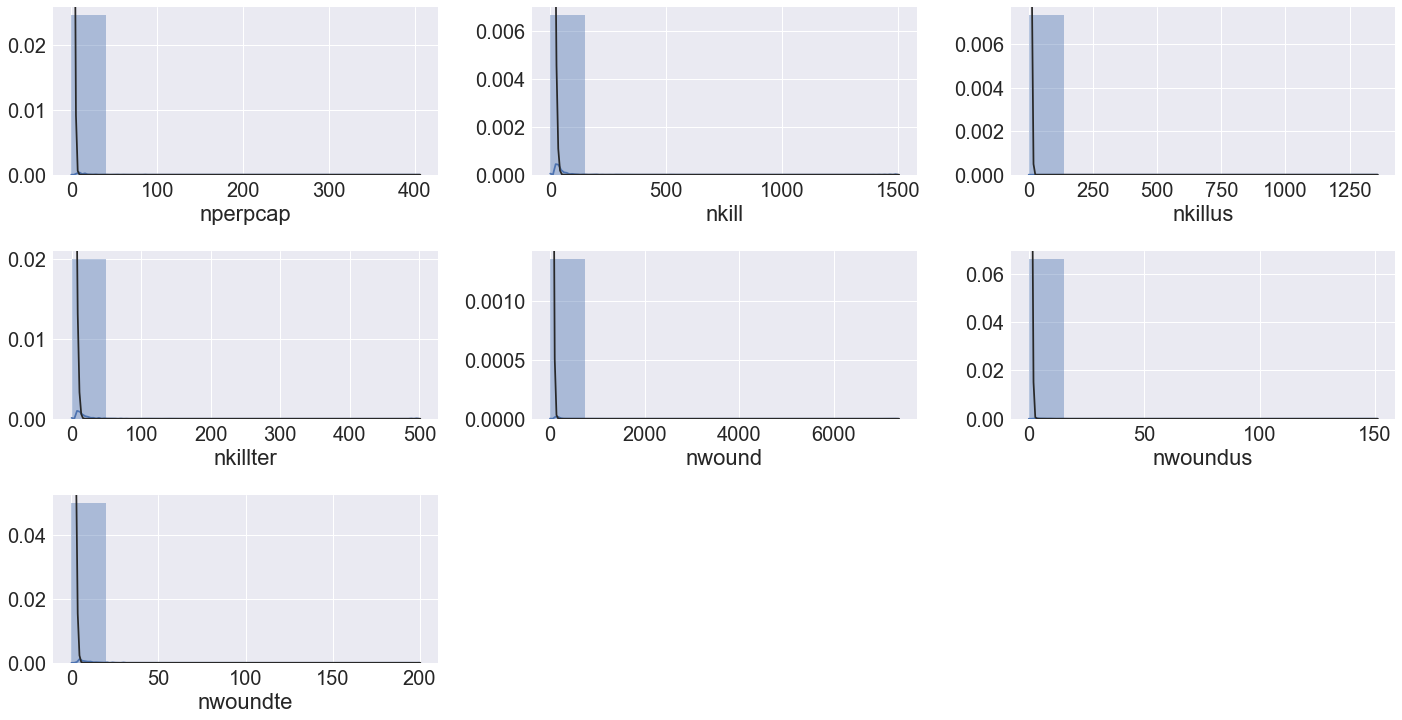

In [10]:
sns.set(font_scale=2)
fig = plt.figure()
for i,col in enumerate(number_features):
    ax = fig.add_subplot(6,3,i+1)
    sns.distplot(dff[col].dropna(),fit=norm, bins=10,ax=ax)

fig.set_size_inches(20,20)
plt.tight_layout()
# sns.boxplot(dff.nwound.dropna(), color = "green", orient = "v")
# sns.violinplot(dff.nwound.dropna(), color = 'cyan')

## Correleation between the number features

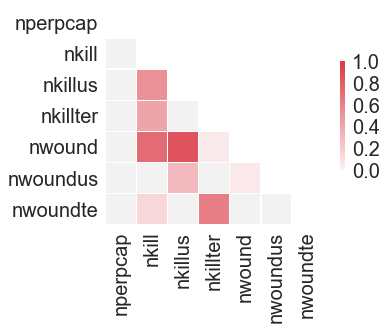

In [11]:
sns.set(style="white",font_scale=2)
corr = dff[number_features].corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(6, 4))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

### Imputing numerical features using MICE algorithm from fancy impute.
https://github.com/iskandr/fancyimpute

In [12]:
def numeric_fill(df,fill_values):
    '''
    Impute the rows that that all of the columns are missing using Imputer from sklearn.
    Then impute other missing values using MICE.
    '''    
    
    imputer = Imputer()
    x = imputer.fit_transform(df)
    x = pd.DataFrame(x,columns = df.columns,index=df.index)
    x = x.loc[df.index[df.isnull().all(1)]] 
    df = df.combine_first(x)

# softimpute 
#    biscaler = BiScaler(verbose=False)
#    X_incomplete_normalized = biscaler.fit_transform(df[numerical_features].values)
#    X_filled_softimpute_normalized = SoftImpute(verbose=False).complete(X_incomplete_normalized)
#    X_filled_softimpute =biscaler.inverse_transform(\
#                           X_filled_softimpute_normalized)
#    X_filled_softimpute = pd.DataFrame(X_filled_softimpute,columns=numerical_features,index=df[numerical_features].index)
#    df = df.combine_first(X_filled_softimpute)

# MICE impute
    mice = MICE(n_imputations=20, impute_type='pmm',verbose=False)
    X_completed = mice.complete(df.values)
    X_completed = pd.DataFrame(X_completed,columns=df.columns,index=df.index)
    df = df.combine_first(X_completed)
    return df

In [13]:
# perform the imputation on numerical features
dg = dff[number_features]
dg = numeric_fill(dg,{})
dff = dff.combine_first(dg)

/usr/local/lib/python3.6/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


#### Save the dataframe (for debugging purposes)

In [14]:
dff.to_pickle('dff_impute.p')

In [15]:
dff = pd.read_pickle('dff_impute.p')

In [16]:
# impute nan in text features by empty
def get_feature_text(col):
    def get_text(df):
        return df[col].fillna("")    
    return get_text

all_features = number_features + binary_features + range_features_txt + range_features_numeric + text_features

In [17]:
# Keep attacks that their responsible terrorist group had done more than (threshold) attacks.
def occur(dff,threshold):
    gname_counts = dff.gname.value_counts()
    gnames_over_threshold = gname_counts[gname_counts > threshold].index
    dff = dff[dff.gname.isin(gnames_over_threshold)]
    dff_nognames = dff[dff.gname == "Unknown"]
    dff = dff[dff.gname != "Unknown"]
    return(dff,dff_nognames)

# lower threshold can be chosen which reducing the accuracy of models. 
# (50 is also chosen to make comparison with available model on the web, but feel free to choose threshold>2)

dff,dff_nognames = occur(dff,50)       
print("number of unique gnames:",dff.gname.unique().size)

number of unique gnames: 99


### Make pipelines

In [18]:
# Pipeline for text features. First step is imputing null with empty.
# Second step is using TfidfVectorizer to vectorize the text.
# At the last step MaxAbsScaler is used to scale each feature by its maximum absolute value.
# I tried TruncatedSVD dimensionality reduction and QunatileTransformer normalization.
# It either didn't work well or didn't make a difference.


pipelines = []
for col in ['summary']:
    get_text_ft = FunctionTransformer(get_feature_text(col), validate=False)
    pipelines.append(make_pipeline(get_text_ft,
                                   TfidfVectorizer(decode_error='ignore'),
                                   MaxAbsScaler()))    
#    pipelines.append(make_pipeline(get_text_ft,
#                                   TfidfVectorizer(decode_error='ignore'),
#                                   TruncatedSVD(n_components=1000)))           
#    pipelines.append(make_pipeline(get_text_ft,
#                                   TfidfVectorizer(decode_error='ignore')))
#    pipelines.append(make_pipeline(get_text_ft,
#                                   TfidfVectorizer(decode_error='ignore'),
#                                    QuantileTransformer()))

union1 = make_union(*pipelines)


# Using LabelBinarizer to change the binary and range features from labels to binary.
# Number features are not touched here.
mapper = DataFrameMapper(
  [(col, LabelBinarizer()) for col in range_features_numeric]
 +[(col, LabelBinarizer()) for col in range_features_txt]   
 +[(col, LabelBinarizer()) for col in binary_features]    
 +[(nomap_col, None) for nomap_col in number_features]   
)


# add the MaxAbsScaler
mac = MaxAbsScaler()
union2 = make_pipeline(mapper,mac)


# I tried PCA dimensionality reduction for these features, it either didn't work well or didn't make a difference.
# pca = PCA(20)
# pipl2 = make_pipeline(mapper,pca)


# Make one pipeline 
union = Pipeline([
    ('features',FeatureUnion([
        ('s1',union1),
        ('s2',union2)
    ]))
])


# Split the data

X_train, X_test, y_train, y_test = train_test_split(dff[all_features],\
                                                    dff.gname,\
                                                    test_size = 0.3,\
                                                    random_state = 15)

# Fit and transform 
X_train_dtm = union.fit_transform(X_train)
X_test_dtm = union.transform(X_test)
x_new_dtm = union.transform(dff_nognames)


assert(X_train_dtm.shape[1]==X_test_dtm.shape[1] and X_train_dtm.shape[1]==x_new_dtm.shape[1])


In [19]:
# Binarize the group names (y)
lba = LabelEncoder()
y_tr = lba.fit_transform(y_train)
y_te = lba.transform(y_test)


### Here we build a XGBClassifier. 

#### The idea is that to use gridsearch only on max_depth to find a priliminary best classifier. Use this classifier to find the most important features. Then use the Baysian optimization to find the best classifier using only important features afterwards. 

In [20]:
param = {
    'max_depth': [3,5,7,9],  # the maximum depth of each tree
    'learning_rate': [0.05],
    'n_estimators':[5],
    'silent':[0],
    'objective':['multi:softmax'],
    'random_state':[12],
    'n_jobs':[7]
}  

bst_grid = GridSearchCV(xgb.XGBClassifier(), param_grid=param,verbose=0,return_train_score=False)
bst = bst_grid.fit(X_train_dtm,y_tr)

/usr/local/lib/python3.6/site-packages/sklearn/model_selection/_search.py:715: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [21]:
preds = bst.predict(X_test_dtm)
print('test score = %.3f' %(accuracy_score(y_te, preds)))

test score = 0.967


#### Find the first 800 important features and reduce the train and test sets.

In [22]:
a = bst.best_estimator_.feature_importances_
f = sorted(range(len(a)), key=lambda i: a[i])[-800:]
X_test_important_dtm = X_test_dtm[:,f]
X_train_important_dtm = X_train_dtm[:,f]
x_new_important_dtm = x_new_dtm[:,f]

## Build XGBClassifier. Use Baysian optimization to find the best parameters.

In [23]:
def sample_loss(args):
    max_depth,min_child_weight,n_estimators,gamma,learning_rate,subsample,colsample_bytree,case = args
    penalty = case[0]
    if penalty == 'l2':
        reg_lambda = case[1]
        reg_alpha = 0
    else:
        reg_alpha = case[1]
        reg_lambda = 0
            
    model = xgb.XGBClassifier(max_depth=max_depth,
                              learning_rate= learning_rate,
                              gamma= gamma ,
                              min_child_weight = min_child_weight ,
                              subsample= subsample ,
                              colsample_bytree=colsample_bytree,
                              reg_lambda= reg_lambda,
                              reg_alpha = reg_alpha,
                              n_estimators= n_estimators ,
                              silent = 0,
                              objective = 'multi:softmax',
                              random_state = 12,
                              n_jobs = 7)
    
    cv_score = cross_validate(model,X=X_train_important_dtm,y=y_train,cv=3,verbose=2,return_train_score=False)
    print('test score = ', cv_score['test_score'].mean())
    return 1-cv_score['test_score'].mean()



space =[
    hp.uniformint('max_depth',3,10),
    hp.uniformint('min_child_weight',1,10),
    hp.uniformint('n_estimators',3,10),
    hp.loguniform('gamma',np.log(0.05),0),
    hp.loguniform('learning_rate',-2,0),
    hp.uniform('subsample',0.6,1),
    hp.uniform('colsample_bytree',0.6,1),
    hp.choice('penalty',[
             ('l2',hp.loguniform('reg_lambda',-5,0)),
             ('l1',hp.loguniform('reg_alpha',-5,0))
    ])
]


best_xgb = fmin(sample_loss,
           space = space,
           algo=tpe.suggest,
           max_evals=200)

print(best_xgb)

[CV]  ................................................................
[CV] ................................................. , total=   6.0s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.2s remaining:    0.0s


[CV] ................................................. , total=   5.7s
[CV]  ................................................................
[CV] ................................................. , total=   6.3s
test score =  0.882183341822056


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   18.2s finished


[CV]  ................................................................
[CV] ................................................. , total=   5.6s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.9s remaining:    0.0s


[CV] ................................................. , total=   5.6s
[CV]  ................................................................
[CV] ................................................. , total=   5.7s
test score =  0.9310245197097943


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   17.2s finished


[CV]  ................................................................
[CV] ................................................. , total=   3.6s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.8s remaining:    0.0s


[CV] ................................................. , total=   3.6s
[CV]  ................................................................
[CV] ................................................. , total=   2.8s
test score =  0.17208331942998323


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   10.2s finished


[CV]  ................................................................
[CV] ................................................. , total=   3.0s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.2s remaining:    0.0s


[CV] ................................................. , total=   3.2s
[CV]  ................................................................
[CV] ................................................. , total=   3.4s
test score =  0.7349614387437918


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    9.8s finished


[CV]  ................................................................
[CV] ................................................. , total=   5.8s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.1s remaining:    0.0s


[CV] ................................................. , total=   5.9s
[CV]  ................................................................
[CV] ................................................. , total=   5.9s
test score =  0.9381399131626971


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   17.9s finished


[CV]  ................................................................
[CV] ................................................. , total=   4.6s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.9s remaining:    0.0s


[CV] ................................................. , total=   5.0s
[CV]  ................................................................
[CV] ................................................. , total=   4.9s
test score =  0.9425811002608077


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   14.8s finished


[CV]  ................................................................
[CV] ................................................. , total=   2.4s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.6s remaining:    0.0s


[CV] ................................................. , total=   2.5s
[CV]  ................................................................
[CV] ................................................. , total=   2.5s
test score =  0.5182142218460108


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    7.6s finished


[CV]  ................................................................
[CV] ................................................. , total=   6.0s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.2s remaining:    0.0s


[CV] ................................................. , total=   6.0s
[CV]  ................................................................
[CV] ................................................. , total=   6.1s
test score =  0.9556224258058726


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   18.3s finished


[CV]  ................................................................
[CV] ................................................. , total=   7.1s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.3s remaining:    0.0s


[CV] ................................................. , total=   7.1s
[CV]  ................................................................
[CV] ................................................. , total=   7.2s
test score =  0.9478443581959904


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   21.6s finished


[CV]  ................................................................
[CV] ................................................. , total=   5.7s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.9s remaining:    0.0s


[CV] ................................................. , total=   5.8s
[CV]  ................................................................
[CV] ................................................. , total=   5.9s
test score =  0.940338854005753


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   17.7s finished


[CV]  ................................................................
[CV] ................................................. , total=   2.9s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.1s remaining:    0.0s


[CV] ................................................. , total=   3.2s
[CV]  ................................................................
[CV] ................................................. , total=   2.9s
test score =  0.10947490314052315


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    9.2s finished


[CV]  ................................................................
[CV] ................................................. , total=   4.3s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.5s remaining:    0.0s


[CV] ................................................. , total=   4.3s
[CV]  ................................................................
[CV] ................................................. , total=   4.3s
test score =  0.9295023535947161


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   13.1s finished


[CV]  ................................................................
[CV] ................................................. , total=   4.4s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.6s remaining:    0.0s


[CV] ................................................. , total=   4.4s
[CV]  ................................................................
[CV] ................................................. , total=   4.4s
test score =  0.9388329170679258


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   13.4s finished


[CV]  ................................................................
[CV] ................................................. , total=   6.3s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.5s remaining:    0.0s


[CV] ................................................. , total=   6.3s
[CV]  ................................................................
[CV] ................................................. , total=   6.5s
test score =  0.9110652507914886


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   19.3s finished


[CV]  ................................................................
[CV] ................................................. , total=   7.0s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.2s remaining:    0.0s


[CV] ................................................. , total=   7.0s
[CV]  ................................................................
[CV] ................................................. , total=   6.9s
test score =  0.9061819102864836


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   21.1s finished


[CV]  ................................................................
[CV] ................................................. , total=   6.2s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.4s remaining:    0.0s


[CV] ................................................. , total=   6.2s
[CV]  ................................................................
[CV] ................................................. , total=   6.4s
test score =  0.9563518619974204


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   19.0s finished


[CV]  ................................................................
[CV] ................................................. , total=   3.4s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.6s remaining:    0.0s


[CV] ................................................. , total=   3.4s
[CV]  ................................................................
[CV] ................................................. , total=   3.5s
test score =  0.9344510032731769


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   10.6s finished


[CV]  ................................................................
[CV] ................................................. , total=   3.9s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.1s remaining:    0.0s


[CV] ................................................. , total=   3.5s
[CV]  ................................................................
[CV] ................................................. , total=   3.8s
test score =  0.13551631650767104


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   11.5s finished


[CV]  ................................................................
[CV] ................................................. , total=   4.0s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.3s remaining:    0.0s


[CV] ................................................. , total=   3.9s
[CV]  ................................................................
[CV] ................................................. , total=   4.3s
test score =  0.9180372491664177


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   12.5s finished


[CV]  ................................................................
[CV] ................................................. , total=   4.5s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.7s remaining:    0.0s


[CV] ................................................. , total=   3.8s
[CV]  ................................................................
[CV] ................................................. , total=   4.6s
test score =  0.812573341631252


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   13.0s finished


[CV]  ................................................................
[CV] ................................................. , total=   4.0s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.2s remaining:    0.0s


[CV] ................................................. , total=   4.0s
[CV]  ................................................................
[CV] ................................................. , total=   4.1s
test score =  0.9478057327928305


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   12.3s finished


[CV]  ................................................................
[CV] ................................................. , total=   3.6s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.8s remaining:    0.0s


[CV] ................................................. , total=   3.5s
[CV]  ................................................................
[CV] ................................................. , total=   3.6s
test score =  0.9450851578948143


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   10.9s finished


[CV]  ................................................................
[CV] ................................................. , total=   6.8s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.0s remaining:    0.0s


[CV] ................................................. , total=   6.6s
[CV]  ................................................................
[CV] ................................................. , total=   6.9s
test score =  0.953383320930636


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   20.5s finished


[CV]  ................................................................
[CV] ................................................. , total=   8.1s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.3s remaining:    0.0s


[CV] ................................................. , total=   8.2s
[CV]  ................................................................
[CV] ................................................. , total=   8.3s
test score =  0.9557257672959117


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   24.8s finished


[CV]  ................................................................
[CV] ................................................. , total=   8.2s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.5s remaining:    0.0s


[CV] ................................................. , total=   8.3s
[CV]  ................................................................
[CV] ................................................. , total=   8.4s
test score =  0.9553779874370191


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   25.2s finished


[CV]  ................................................................
[CV] ................................................. , total=   8.4s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.6s remaining:    0.0s


[CV] ................................................. , total=   8.4s
[CV]  ................................................................
[CV] ................................................. , total=   8.6s
test score =  0.9443221296766272


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   25.5s finished


[CV]  ................................................................
[CV] ................................................. , total=   7.0s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.2s remaining:    0.0s


[CV] ................................................. , total=   7.2s
[CV]  ................................................................
[CV] ................................................. , total=   7.2s
test score =  0.9543612868232701


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   21.6s finished


[CV]  ................................................................
[CV] ................................................. , total=   8.5s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.7s remaining:    0.0s


[CV] ................................................. , total=   8.7s
[CV]  ................................................................
[CV] ................................................. , total=   8.7s
test score =  0.9567694512058531


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   26.0s finished


[CV]  ................................................................
[CV] ................................................. , total=   8.6s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.9s remaining:    0.0s


[CV] ................................................. , total=   8.6s
[CV]  ................................................................
[CV] ................................................. , total=   8.7s
test score =  0.94714680196233


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   26.2s finished


[CV]  ................................................................
[CV] ................................................. , total=   6.2s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.4s remaining:    0.0s


[CV] ................................................. , total=   6.3s
[CV]  ................................................................
[CV] ................................................. , total=   6.3s
test score =  0.929802925013405


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   19.0s finished


[CV]  ................................................................
[CV] ................................................. , total=   7.4s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.6s remaining:    0.0s


[CV] ................................................. , total=   7.5s
[CV]  ................................................................
[CV] ................................................. , total=   7.6s
test score =  0.95446531641669


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   22.8s finished


[CV]  ................................................................
[CV] ................................................. , total=   6.8s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.0s remaining:    0.0s


[CV] ................................................. , total=   7.0s
[CV]  ................................................................
[CV] ................................................. , total=   7.0s
test score =  0.9524118739392381


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   21.0s finished


[CV]  ................................................................
[CV] ................................................. , total=   6.6s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.8s remaining:    0.0s


[CV] ................................................. , total=   6.8s
[CV]  ................................................................
[CV] ................................................. , total=   6.8s
test score =  0.9533132545308444


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   20.3s finished


[CV]  ................................................................
[CV] ................................................. , total=   8.0s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.2s remaining:    0.0s


[CV] ................................................. , total=   8.2s
[CV]  ................................................................
[CV] ................................................. , total=   8.3s
test score =  0.9600878706203786


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   24.8s finished


[CV]  ................................................................
[CV] ................................................. , total=   4.6s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.8s remaining:    0.0s


[CV] ................................................. , total=   4.1s
[CV]  ................................................................
[CV] ................................................. , total=   3.8s
test score =  0.12198873076544704


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   12.7s finished


[CV]  ................................................................
[CV] ................................................. , total=   6.1s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.3s remaining:    0.0s


[CV] ................................................. , total=   6.0s
[CV]  ................................................................
[CV] ................................................. , total=   6.2s
test score =  0.9434786476967245


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   18.5s finished


[CV]  ................................................................
[CV] ................................................. , total=   8.2s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.4s remaining:    0.0s


[CV] ................................................. , total=   8.3s
[CV]  ................................................................
[CV] ................................................. , total=   8.2s
test score =  0.9457853651321696


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   25.0s finished


[CV]  ................................................................
[CV] ................................................. , total=   4.6s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.8s remaining:    0.0s


[CV] ................................................. , total=   4.7s
[CV]  ................................................................
[CV] ................................................. , total=   4.8s
test score =  0.9331794622386886


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   14.3s finished


[CV]  ................................................................
[CV] ................................................. , total=   7.1s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.3s remaining:    0.0s


[CV] ................................................. , total=   7.0s
[CV]  ................................................................
[CV] ................................................. , total=   7.1s
test score =  0.9308575665994233


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   21.5s finished


[CV]  ................................................................
[CV] ................................................. , total=   5.1s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.3s remaining:    0.0s


[CV] ................................................. , total=   4.7s
[CV]  ................................................................
[CV] ................................................. , total=   5.4s
test score =  0.9184638907600844


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   15.4s finished


[CV]  ................................................................
[CV] ................................................. , total=   7.6s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.9s remaining:    0.0s


[CV] ................................................. , total=   7.7s
[CV]  ................................................................
[CV] ................................................. , total=   7.9s
test score =  0.954435111802649


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   23.4s finished


[CV]  ................................................................
[CV] ................................................. , total=   8.3s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.5s remaining:    0.0s


[CV] ................................................. , total=   8.7s
[CV]  ................................................................
[CV] ................................................. , total=   8.4s
test score =  0.9555470243462761


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   25.6s finished


[CV]  ................................................................
[CV] ................................................. , total=   3.5s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.7s remaining:    0.0s


[CV] ................................................. , total=   3.5s
[CV]  ................................................................
[CV] ................................................. , total=   3.5s
test score =  0.896476051195232


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   10.6s finished


[CV]  ................................................................
[CV] ................................................. , total=   6.9s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.1s remaining:    0.0s


[CV] ................................................. , total=   7.0s
[CV]  ................................................................
[CV] ................................................. , total=   7.0s
test score =  0.9502776265849725


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   21.0s finished


[CV]  ................................................................
[CV] ................................................. , total=   5.3s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.5s remaining:    0.0s


[CV] ................................................. , total=   5.4s
[CV]  ................................................................
[CV] ................................................. , total=   5.4s
test score =  0.9258677615870141


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   16.4s finished


[CV]  ................................................................
[CV] ................................................. , total=   2.7s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.9s remaining:    0.0s


[CV] ................................................. , total=   2.8s
[CV]  ................................................................
[CV] ................................................. , total=   2.7s
test score =  0.8281804991565854


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    8.5s finished


[CV]  ................................................................
[CV] ................................................. , total=   8.6s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.8s remaining:    0.0s


[CV] ................................................. , total=   8.7s
[CV]  ................................................................
[CV] ................................................. , total=   9.0s
test score =  0.9606105029332763


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   26.5s finished


[CV]  ................................................................
[CV] ................................................. , total=   4.8s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.0s remaining:    0.0s


[CV] ................................................. , total=   4.8s
[CV]  ................................................................
[CV] ................................................. , total=   4.9s
test score =  0.9391856125141119


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   14.7s finished


[CV]  ................................................................
[CV] ................................................. , total=   6.0s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.2s remaining:    0.0s


[CV] ................................................. , total=   6.1s
[CV]  ................................................................
[CV] ................................................. , total=   6.1s
test score =  0.9509096235510945


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   18.4s finished


[CV]  ................................................................
[CV] ................................................. , total=   4.0s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.2s remaining:    0.0s


[CV] ................................................. , total=   3.5s
[CV]  ................................................................
[CV] ................................................. , total=   3.9s
test score =  0.6323786054847065


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   11.5s finished


[CV]  ................................................................
[CV] ................................................. , total=   3.9s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.1s remaining:    0.0s


[CV] ................................................. , total=   3.9s
[CV]  ................................................................
[CV] ................................................. , total=   4.2s
test score =  0.8875542559430919


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   12.2s finished


[CV]  ................................................................
[CV] ................................................. , total=   6.8s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.0s remaining:    0.0s


[CV] ................................................. , total=   7.5s
[CV]  ................................................................
[CV] ................................................. , total=   7.0s
test score =  0.7272203705688375


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   21.5s finished


[CV]  ................................................................
[CV] ................................................. , total=   4.0s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.2s remaining:    0.0s


[CV] ................................................. , total=   4.1s
[CV]  ................................................................
[CV] ................................................. , total=   4.2s
test score =  0.9261584149369163


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   12.5s finished


[CV]  ................................................................
[CV] ................................................. , total=   4.4s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.7s remaining:    0.0s


[CV] ................................................. , total=   3.6s
[CV]  ................................................................
[CV] ................................................. , total=   4.1s
test score =  0.20955019982632728


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   12.4s finished


[CV]  ................................................................
[CV] ................................................. , total=   7.0s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.2s remaining:    0.0s


[CV] ................................................. , total=   7.0s
[CV]  ................................................................
[CV] ................................................. , total=   7.1s
test score =  0.9582737396335591


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   21.2s finished


[CV]  ................................................................
[CV] ................................................. , total=   5.8s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.0s remaining:    0.0s


[CV] ................................................. , total=   5.8s
[CV]  ................................................................
[CV] ................................................. , total=   6.0s
test score =  0.9017853406853567


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   17.8s finished


[CV]  ................................................................
[CV] ................................................. , total=   5.6s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.8s remaining:    0.0s


[CV] ................................................. , total=   5.6s
[CV]  ................................................................
[CV] ................................................. , total=   5.8s
test score =  0.9074025793179848


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   17.2s finished


[CV]  ................................................................
[CV] ................................................. , total=   5.3s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.5s remaining:    0.0s


[CV] ................................................. , total=   5.8s
[CV]  ................................................................
[CV] ................................................. , total=   5.5s
test score =  0.9452179786074626


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   16.8s finished


[CV]  ................................................................
[CV] ................................................. , total=   5.5s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.7s remaining:    0.0s


[CV] ................................................. , total=   5.5s
[CV]  ................................................................
[CV] ................................................. , total=   5.6s
test score =  0.9544696269479777


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   16.8s finished


[CV]  ................................................................
[CV] ................................................. , total=   8.6s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.8s remaining:    0.0s


[CV] ................................................. , total=   8.9s
[CV]  ................................................................
[CV] ................................................. , total=   8.6s
test score =  0.9552341943583315


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   26.3s finished


[CV]  ................................................................
[CV] ................................................. , total=   4.6s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.8s remaining:    0.0s


[CV] ................................................. , total=   4.6s
[CV]  ................................................................
[CV] ................................................. , total=   4.6s
test score =  0.9376164871009548


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   14.0s finished


[CV]  ................................................................
[CV] ................................................. , total=   6.2s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.4s remaining:    0.0s


[CV] ................................................. , total=   6.6s
[CV]  ................................................................
[CV] ................................................. , total=   6.5s
test score =  0.9433028842677933


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   19.5s finished


[CV]  ................................................................
[CV] ................................................. , total=   4.0s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.2s remaining:    0.0s


[CV] ................................................. , total=   4.3s
[CV]  ................................................................
[CV] ................................................. , total=   4.4s
test score =  0.23829146433864704


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   12.9s finished


[CV]  ................................................................
[CV] ................................................. , total=   3.6s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.9s remaining:    0.0s


[CV] ................................................. , total=   3.8s
[CV]  ................................................................
[CV] ................................................. , total=   3.7s
test score =  0.8991326359609468


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   11.3s finished


[CV]  ................................................................
[CV] ................................................. , total=   6.3s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.5s remaining:    0.0s


[CV] ................................................. , total=   6.4s
[CV]  ................................................................
[CV] ................................................. , total=   6.4s
test score =  0.945994146601096


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   19.3s finished


[CV]  ................................................................
[CV] ................................................. , total=   7.2s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.4s remaining:    0.0s


[CV] ................................................. , total=   7.3s
[CV]  ................................................................
[CV] ................................................. , total=   7.3s
test score =  0.9590398346554622


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   22.0s finished


[CV]  ................................................................
[CV] ................................................. , total=   7.0s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.3s remaining:    0.0s


[CV] ................................................. , total=   7.2s
[CV]  ................................................................
[CV] ................................................. , total=   7.2s
test score =  0.9601549159757785


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   21.7s finished


[CV]  ................................................................
[CV] ................................................. , total=   9.3s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    9.5s remaining:    0.0s


[CV] ................................................. , total=   9.5s
[CV]  ................................................................
[CV] ................................................. , total=   9.4s
test score =  0.9621440355682829


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   28.4s finished


[CV]  ................................................................
[CV] ................................................. , total=   6.1s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.3s remaining:    0.0s


[CV] ................................................. , total=   6.2s
[CV]  ................................................................
[CV] ................................................. , total=   6.2s
test score =  0.9494446864811262


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   18.7s finished


[CV]  ................................................................
[CV] ................................................. , total=   9.0s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    9.2s remaining:    0.0s


[CV] ................................................. , total=   9.1s
[CV]  ................................................................
[CV] ................................................. , total=   9.2s
test score =  0.9634382341145682


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   27.5s finished


[CV]  ................................................................
[CV] ................................................. , total=   8.8s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    9.0s remaining:    0.0s


[CV] ................................................. , total=   8.7s
[CV]  ................................................................
[CV] ................................................. , total=   8.7s
test score =  0.9591104871856609


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   26.4s finished


[CV]  ................................................................
[CV] ................................................. , total=   9.8s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   10.0s remaining:    0.0s


[CV] ................................................. , total=   9.9s
[CV]  ................................................................
[CV] ................................................. , total=   9.9s
test score =  0.9636484296414528


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   29.8s finished


[CV]  ................................................................
[CV] ................................................. , total=   7.4s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.7s remaining:    0.0s


[CV] ................................................. , total=   7.4s
[CV]  ................................................................
[CV] ................................................. , total=   7.6s
test score =  0.9576468548556963


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   22.6s finished


[CV]  ................................................................
[CV] ................................................. , total=   9.8s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   10.0s remaining:    0.0s


[CV] ................................................. , total=   9.9s
[CV]  ................................................................
[CV] ................................................. , total=   9.8s
test score =  0.9622871668141694


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   29.7s finished


[CV]  ................................................................
[CV] ................................................. , total=  10.0s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   10.2s remaining:    0.0s


[CV] ................................................. , total=  10.1s
[CV]  ................................................................
[CV] ................................................. , total=  10.3s
test score =  0.9616181514313209


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   30.6s finished


[CV]  ................................................................
[CV] ................................................. , total=   9.3s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    9.5s remaining:    0.0s


[CV] ................................................. , total=   9.1s
[CV]  ................................................................
[CV] ................................................. , total=   9.1s
test score =  0.9604375865458602


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   27.7s finished


[CV]  ................................................................
[CV] ................................................. , total=   8.7s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.9s remaining:    0.0s


[CV] ................................................. , total=   8.7s
[CV]  ................................................................
[CV] ................................................. , total=   8.9s
test score =  0.960120752508694


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   26.5s finished


[CV]  ................................................................
[CV] ................................................. , total=  10.9s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   11.1s remaining:    0.0s


[CV] ................................................. , total=  11.4s
[CV]  ................................................................
[CV] ................................................. , total=  11.0s
test score =  0.9621089001138405


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   33.4s finished


[CV]  ................................................................
[CV] ................................................. , total=   8.3s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.6s remaining:    0.0s


[CV] ................................................. , total=   8.4s
[CV]  ................................................................
[CV] ................................................. , total=   8.4s
test score =  0.9546415371693294


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   25.4s finished


[CV]  ................................................................
[CV] ................................................. , total=   9.2s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    9.4s remaining:    0.0s


[CV] ................................................. , total=   9.1s
[CV]  ................................................................
[CV] ................................................. , total=   9.2s
test score =  0.9602974158950798


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   27.7s finished


[CV]  ................................................................
[CV] ................................................. , total=   9.4s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    9.7s remaining:    0.0s


[CV] ................................................. , total=   9.8s
[CV]  ................................................................
[CV] ................................................. , total=   9.7s
test score =  0.9602926364594664


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   29.1s finished


[CV]  ................................................................
[CV] ................................................. , total=   9.1s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    9.3s remaining:    0.0s


[CV] ................................................. , total=   9.1s
[CV]  ................................................................
[CV] ................................................. , total=   9.1s
test score =  0.9603632700640667


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   27.6s finished


[CV]  ................................................................
[CV] ................................................. , total=   7.0s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.2s remaining:    0.0s


[CV] ................................................. , total=   7.0s
[CV]  ................................................................
[CV] ................................................. , total=   7.0s
test score =  0.9401298228315557


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   21.2s finished


[CV]  ................................................................
[CV] ................................................. , total=   6.7s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.9s remaining:    0.0s


[CV] ................................................. , total=   6.8s
[CV]  ................................................................
[CV] ................................................. , total=   6.9s
test score =  0.9327733185362574


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   20.7s finished


[CV]  ................................................................
[CV] ................................................. , total=  10.2s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   10.4s remaining:    0.0s


[CV] ................................................. , total=  10.3s
[CV]  ................................................................
[CV] ................................................. , total=  10.2s
test score =  0.9627746258214277


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   30.9s finished


[CV]  ................................................................
[CV] ................................................. , total=   7.0s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.2s remaining:    0.0s


[CV] ................................................. , total=   6.9s
[CV]  ................................................................
[CV] ................................................. , total=   6.9s
test score =  0.9383226192010125


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   21.0s finished


[CV]  ................................................................
[CV] ................................................. , total=   8.2s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.5s remaining:    0.0s


[CV] ................................................. , total=   7.9s
[CV]  ................................................................
[CV] ................................................. , total=   8.3s
test score =  0.747074000091561


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   24.7s finished


[CV]  ................................................................
[CV] ................................................. , total=   9.6s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    9.8s remaining:    0.0s


[CV] ................................................. , total=   9.6s
[CV]  ................................................................
[CV] ................................................. , total=   9.4s
test score =  0.960363546039917


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   28.8s finished


[CV]  ................................................................
[CV] ................................................. , total=   7.8s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.0s remaining:    0.0s


[CV] ................................................. , total=   7.9s
[CV]  ................................................................
[CV] ................................................. , total=   7.9s
test score =  0.9567728996308832


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   23.8s finished


[CV]  ................................................................
[CV] ................................................. , total=   5.3s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.5s remaining:    0.0s


[CV] ................................................. , total=   5.1s
[CV]  ................................................................
[CV] ................................................. , total=   5.1s
test score =  0.9446604147860697


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   15.7s finished


[CV]  ................................................................
[CV] ................................................. , total=   9.4s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    9.6s remaining:    0.0s


[CV] ................................................. , total=   9.5s
[CV]  ................................................................
[CV] ................................................. , total=   9.5s
test score =  0.9581321811954


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   28.6s finished


[CV]  ................................................................
[CV] ................................................. , total=   7.1s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.3s remaining:    0.0s


[CV] ................................................. , total=   7.0s
[CV]  ................................................................
[CV] ................................................. , total=   7.0s
test score =  0.908733822551576


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   21.2s finished


[CV]  ................................................................
[CV] ................................................. , total=  10.2s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   10.4s remaining:    0.0s


[CV] ................................................. , total=  10.4s
[CV]  ................................................................
[CV] ................................................. , total=  10.3s
test score =  0.9607164191614705


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   31.1s finished


[CV]  ................................................................
[CV] ................................................. , total=   8.0s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.2s remaining:    0.0s


[CV] ................................................. , total=   8.0s
[CV]  ................................................................
[CV] ................................................. , total=   8.1s
test score =  0.9527627316193183


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   24.4s finished


[CV]  ................................................................
[CV] ................................................. , total=   6.4s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.6s remaining:    0.0s


[CV] ................................................. , total=   6.3s
[CV]  ................................................................
[CV] ................................................. , total=   6.3s
test score =  0.7076982203619285


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   19.1s finished


[CV]  ................................................................
[CV] ................................................. , total=   8.3s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.5s remaining:    0.0s


[CV] ................................................. , total=   8.8s
[CV]  ................................................................
[CV] ................................................. , total=   8.7s
test score =  0.9617585907129707


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   25.9s finished


[CV]  ................................................................
[CV] ................................................. , total=   6.4s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.6s remaining:    0.0s


[CV] ................................................. , total=   6.6s
[CV]  ................................................................
[CV] ................................................. , total=   6.5s
test score =  0.9584812731392773


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   19.7s finished


[CV]  ................................................................
[CV] ................................................. , total=   9.1s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    9.3s remaining:    0.0s


[CV] ................................................. , total=   9.2s
[CV]  ................................................................
[CV] ................................................. , total=   9.2s
test score =  0.9575043775344841


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   27.7s finished


[CV]  ................................................................
[CV] ................................................. , total=   7.2s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.4s remaining:    0.0s


[CV] ................................................. , total=   6.4s
[CV]  ................................................................
[CV] ................................................. , total=   6.4s
test score =  0.9561850481480741


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   20.3s finished


[CV]  ................................................................
[CV] ................................................. , total=   9.7s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    9.9s remaining:    0.0s


[CV] ................................................. , total=   9.9s
[CV]  ................................................................
[CV] ................................................. , total=  10.0s
test score =  0.9607840317216793


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   29.7s finished


[CV]  ................................................................
[CV] ................................................. , total=   4.4s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.6s remaining:    0.0s


[CV] ................................................. , total=   4.4s
[CV]  ................................................................
[CV] ................................................. , total=   5.3s
test score =  0.15608588035292176


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   14.3s finished


[CV]  ................................................................
[CV] ................................................. , total=   4.9s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.1s remaining:    0.0s


[CV] ................................................. , total=   5.1s
[CV]  ................................................................
[CV] ................................................. , total=   3.9s
test score =  0.8107375677642379


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   14.1s finished


[CV]  ................................................................
[CV] ................................................. , total=   9.8s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   10.0s remaining:    0.0s


[CV] ................................................. , total=   9.9s
[CV]  ................................................................
[CV] ................................................. , total=   9.7s
test score =  0.9588688128109474


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   29.6s finished


[CV]  ................................................................
[CV] ................................................. , total=   3.5s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.7s remaining:    0.0s


[CV] ................................................. , total=   3.5s
[CV]  ................................................................
[CV] ................................................. , total=   3.5s
test score =  0.8982923416833318


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   10.7s finished


[CV]  ................................................................
[CV] ................................................. , total=   5.2s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.5s remaining:    0.0s


[CV] ................................................. , total=   6.0s
[CV]  ................................................................
[CV] ................................................. , total=   5.3s
test score =  0.936154729825147


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   16.8s finished


[CV]  ................................................................
[CV] ................................................. , total=   8.6s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.8s remaining:    0.0s


[CV] ................................................. , total=   8.8s
[CV]  ................................................................
[CV] ................................................. , total=   8.7s
test score =  0.9614113475526708


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   26.3s finished


[CV]  ................................................................
[CV] ................................................. , total=   8.0s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.2s remaining:    0.0s


[CV] ................................................. , total=   8.1s
[CV]  ................................................................
[CV] ................................................. , total=   8.4s
test score =  0.956246331063031


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   24.7s finished


[CV]  ................................................................
[CV] ................................................. , total=   8.4s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.7s remaining:    0.0s


[CV] ................................................. , total=   8.5s
[CV]  ................................................................
[CV] ................................................. , total=   8.5s
test score =  0.9540843823661219


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   25.7s finished


[CV]  ................................................................
[CV] ................................................. , total=   9.8s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   10.0s remaining:    0.0s


[CV] ................................................. , total=   9.8s
[CV]  ................................................................
[CV] ................................................. , total=   9.9s
test score =  0.9599481236777457


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   29.7s finished


[CV]  ................................................................
[CV] ................................................. , total=   8.0s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.2s remaining:    0.0s


[CV] ................................................. , total=   8.1s
[CV]  ................................................................
[CV] ................................................. , total=   8.1s
test score =  0.9512262835853839


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   24.4s finished


[CV]  ................................................................
[CV] ................................................. , total=   7.0s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.2s remaining:    0.0s


[CV] ................................................. , total=   7.1s
[CV]  ................................................................
[CV] ................................................. , total=   7.0s
test score =  0.9460607151440433


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   21.4s finished


[CV]  ................................................................
[CV] ................................................. , total=   4.8s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.0s remaining:    0.0s


[CV] ................................................. , total=   4.8s
[CV]  ................................................................
[CV] ................................................. , total=   4.7s
test score =  0.9436534091952277


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   14.5s finished


[CV]  ................................................................
[CV] ................................................. , total=   6.1s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.4s remaining:    0.0s


[CV] ................................................. , total=   6.2s
[CV]  ................................................................
[CV] ................................................. , total=   6.2s
test score =  0.9499734365852016


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   18.8s finished


[CV]  ................................................................
[CV] ................................................. , total=   7.3s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.5s remaining:    0.0s


[CV] ................................................. , total=   7.3s
[CV]  ................................................................
[CV] ................................................. , total=   7.3s
test score =  0.9527587312425875


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   22.2s finished


[CV]  ................................................................
[CV] ................................................. , total=   8.4s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.6s remaining:    0.0s


[CV] ................................................. , total=   8.2s
[CV]  ................................................................
[CV] ................................................. , total=   6.0s
test score =  0.6992748252393901


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   22.8s finished


[CV]  ................................................................
[CV] ................................................. , total=   4.6s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.8s remaining:    0.0s


[CV] ................................................. , total=   4.6s
[CV]  ................................................................
[CV] ................................................. , total=   4.7s
test score =  0.9512940322972723


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   14.1s finished


[CV]  ................................................................
[CV] ................................................. , total=   5.9s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.1s remaining:    0.0s


[CV] ................................................. , total=   5.9s
[CV]  ................................................................
[CV] ................................................. , total=   5.9s
test score =  0.958652431135472


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   17.8s finished


[CV]  ................................................................
[CV] ................................................. , total=   6.8s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.1s remaining:    0.0s


[CV] ................................................. , total=   6.7s
[CV]  ................................................................
[CV] ................................................. , total=   6.9s
test score =  0.9485717673654475


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   20.6s finished


[CV]  ................................................................
[CV] ................................................. , total=   8.9s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    9.2s remaining:    0.0s


[CV] ................................................. , total=   9.2s
[CV]  ................................................................
[CV] ................................................. , total=   9.2s
test score =  0.9612724285375891


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   27.6s finished


[CV]  ................................................................
[CV] ................................................. , total=   8.0s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.2s remaining:    0.0s


[CV] ................................................. , total=   7.8s
[CV]  ................................................................
[CV] ................................................. , total=   7.8s
test score =  0.9484345536372824


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   23.8s finished


[CV]  ................................................................
[CV] ................................................. , total=   7.4s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.6s remaining:    0.0s


[CV] ................................................. , total=   6.0s
[CV]  ................................................................
[CV] ................................................. , total=   5.6s
test score =  0.5084924741602892


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   19.2s finished


[CV]  ................................................................
[CV] ................................................. , total=   5.1s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.3s remaining:    0.0s


[CV] ................................................. , total=   5.1s
[CV]  ................................................................
[CV] ................................................. , total=   5.2s
test score =  0.9232440019328193


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   15.6s finished


[CV]  ................................................................
[CV] ................................................. , total=   5.0s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.3s remaining:    0.0s


[CV] ................................................. , total=   5.0s
[CV]  ................................................................
[CV] ................................................. , total=   5.0s
test score =  0.9403007390306063


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   15.2s finished


[CV]  ................................................................
[CV] ................................................. , total=   6.9s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.1s remaining:    0.0s


[CV] ................................................. , total=   7.0s
[CV]  ................................................................
[CV] ................................................. , total=   7.0s
test score =  0.944981359081067


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   21.1s finished


[CV]  ................................................................
[CV] ................................................. , total=   9.8s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   10.0s remaining:    0.0s


[CV] ................................................. , total=  10.1s
[CV]  ................................................................
[CV] ................................................. , total=   9.8s
test score =  0.9634002742166999


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   29.9s finished


[CV]  ................................................................
[CV] ................................................. , total=   9.2s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    9.4s remaining:    0.0s


[CV] ................................................. , total=   9.2s
[CV]  ................................................................
[CV] ................................................. , total=   9.0s
test score =  0.9431691715058174


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   27.6s finished


[CV]  ................................................................
[CV] ................................................. , total=   8.7s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.9s remaining:    0.0s


[CV] ................................................. , total=   8.8s
[CV]  ................................................................
[CV] ................................................. , total=   8.9s
test score =  0.9561083724546898


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   26.7s finished


[CV]  ................................................................
[CV] ................................................. , total=   9.5s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    9.8s remaining:    0.0s


[CV] ................................................. , total=   9.1s
[CV]  ................................................................
[CV] ................................................. , total=   7.1s
test score =  0.9544302224859352


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   26.0s finished


[CV]  ................................................................
[CV] ................................................. , total=   8.2s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.4s remaining:    0.0s


[CV] ................................................. , total=   7.8s
[CV]  ................................................................
[CV] ................................................. , total=   7.7s
test score =  0.944108134046468


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   24.0s finished


[CV]  ................................................................
[CV] ................................................. , total=  13.1s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   13.3s remaining:    0.0s


[CV] ................................................. , total=  10.5s
[CV]  ................................................................
[CV] ................................................. , total=  10.8s
test score =  0.9643078257037886


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   34.6s finished


[CV]  ................................................................
[CV] ................................................. , total=  10.3s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   10.6s remaining:    0.0s


[CV] ................................................. , total=  10.0s
[CV]  ................................................................
[CV] ................................................. , total=  10.0s
test score =  0.9635409705486015


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   30.6s finished


[CV]  ................................................................
[CV] ................................................. , total=   9.7s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    9.9s remaining:    0.0s


[CV] ................................................. , total=  10.3s
[CV]  ................................................................
[CV] ................................................. , total=   9.6s
test score =  0.957330443963532


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   29.8s finished


[CV]  ................................................................
[CV] ................................................. , total=  10.4s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   10.6s remaining:    0.0s


[CV] ................................................. , total=  10.8s
[CV]  ................................................................
[CV] ................................................. , total=  11.0s
test score =  0.9627705460698125


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   32.4s finished


[CV]  ................................................................
[CV] ................................................. , total=   6.2s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.4s remaining:    0.0s


[CV] ................................................. , total=   6.8s
[CV]  ................................................................
[CV] ................................................. , total=   5.1s
test score =  0.4711383190671526


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   18.3s finished


[CV]  ................................................................
[CV] ................................................. , total=   9.1s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    9.3s remaining:    0.0s


[CV] ................................................. , total=   5.6s
[CV]  ................................................................
[CV] ................................................. , total=   5.0s
test score =  0.08746408052201737


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   19.9s finished


[CV]  ................................................................
[CV] ................................................. , total=   9.8s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   10.0s remaining:    0.0s


[CV] ................................................. , total=  12.2s
[CV]  ................................................................
[CV] ................................................. , total=  10.6s
test score =  0.9458547507735618


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   32.8s finished


[CV]  ................................................................
[CV] ................................................. , total=   8.2s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.4s remaining:    0.0s


[CV] ................................................. , total=   7.3s
[CV]  ................................................................
[CV] ................................................. , total=   7.7s
test score =  0.9424694184828257


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   23.3s finished


[CV]  ................................................................
[CV] ................................................. , total=   3.5s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.7s remaining:    0.0s


[CV] ................................................. , total=   3.5s
[CV]  ................................................................
[CV] ................................................. , total=   3.6s
test score =  0.8771210473941892


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   10.9s finished


[CV]  ................................................................
[CV] ................................................. , total=   8.4s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.7s remaining:    0.0s


[CV] ................................................. , total=   8.8s
[CV]  ................................................................
[CV] ................................................. , total=   8.3s
test score =  0.9603312997138231


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   25.8s finished


[CV]  ................................................................
[CV] ................................................. , total=  10.5s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   10.7s remaining:    0.0s


[CV] ................................................. , total=   6.8s
[CV]  ................................................................
[CV] ................................................. , total=   9.2s
test score =  0.738247497096141


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   26.7s finished


[CV]  ................................................................
[CV] ................................................. , total=  10.7s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   10.9s remaining:    0.0s


[CV] ................................................. , total=  10.7s
[CV]  ................................................................
[CV] ................................................. , total=  11.0s
test score =  0.9573314043702724


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   32.6s finished


[CV]  ................................................................
[CV] ................................................. , total=   6.3s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.5s remaining:    0.0s


[CV] ................................................. , total=   5.4s
[CV]  ................................................................
[CV] ................................................. , total=   5.2s
test score =  0.9454332820869703


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   17.1s finished


[CV]  ................................................................
[CV] ................................................. , total=   8.0s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.2s remaining:    0.0s


[CV] ................................................. , total=   7.9s
[CV]  ................................................................
[CV] ................................................. , total=   9.0s
test score =  0.9513306990357542


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   25.1s finished


[CV]  ................................................................
[CV] ................................................. , total=   9.3s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    9.5s remaining:    0.0s


[CV] ................................................. , total=   9.4s
[CV]  ................................................................
[CV] ................................................. , total=  10.6s
test score =  0.9593555006674501


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   29.5s finished


[CV]  ................................................................
[CV] ................................................. , total=   8.1s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.4s remaining:    0.0s


[CV] ................................................. , total=   6.9s
[CV]  ................................................................
[CV] ................................................. , total=   7.0s
test score =  0.9280898135930848


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   22.2s finished


[CV]  ................................................................
[CV] ................................................. , total=  10.0s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   10.2s remaining:    0.0s


[CV] ................................................. , total=   9.3s
[CV]  ................................................................
[CV] ................................................. , total=   9.3s
test score =  0.9622495207433484


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   28.8s finished


[CV]  ................................................................
[CV] ................................................. , total=   9.1s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    9.3s remaining:    0.0s


[CV] ................................................. , total=   9.2s
[CV]  ................................................................
[CV] ................................................. , total=  10.5s
test score =  0.9635070226080815


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   29.0s finished


[CV]  ................................................................
[CV] ................................................. , total=  11.7s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   11.9s remaining:    0.0s


[CV] ................................................. , total=  11.1s
[CV]  ................................................................
[CV] ................................................. , total=  10.6s
test score =  0.9608569756692019


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   33.6s finished


[CV]  ................................................................
[CV] ................................................. , total=  10.6s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   10.8s remaining:    0.0s


[CV] ................................................. , total=  10.4s
[CV]  ................................................................
[CV] ................................................. , total=  11.5s
test score =  0.9641005266502333


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   32.7s finished


[CV]  ................................................................
[CV] ................................................. , total=  10.1s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   10.3s remaining:    0.0s


[CV] ................................................. , total=   9.5s
[CV]  ................................................................
[CV] ................................................. , total=  10.1s
test score =  0.9617615323824782


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   29.9s finished


[CV]  ................................................................
[CV] ................................................. , total=   9.7s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    9.9s remaining:    0.0s


[CV] ................................................. , total=  10.0s
[CV]  ................................................................
[CV] ................................................. , total=   9.9s
test score =  0.9611696994485368


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   29.8s finished


[CV]  ................................................................
[CV] ................................................. , total=  11.6s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   11.8s remaining:    0.0s


[CV] ................................................. , total=  12.5s
[CV]  ................................................................
[CV] ................................................. , total=  12.0s
test score =  0.9649726856326276


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   36.4s finished


[CV]  ................................................................
[CV] ................................................. , total=   8.9s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    9.1s remaining:    0.0s


[CV] ................................................. , total=   8.2s
[CV]  ................................................................
[CV] ................................................. , total=   8.2s
test score =  0.9595286851225898


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   25.5s finished


[CV]  ................................................................
[CV] ................................................. , total=   9.9s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   10.1s remaining:    0.0s


[CV] ................................................. , total=  10.4s
[CV]  ................................................................
[CV] ................................................. , total=   9.8s
test score =  0.9607133828639708


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   30.4s finished


[CV]  ................................................................
[CV] ................................................. , total=  10.4s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   10.6s remaining:    0.0s


[CV] ................................................. , total=  10.5s
[CV]  ................................................................
[CV] ................................................. , total=  10.7s
test score =  0.9643095651694115


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   31.8s finished


[CV]  ................................................................
[CV] ................................................. , total=  10.5s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   10.7s remaining:    0.0s


[CV] ................................................. , total=  11.3s
[CV]  ................................................................
[CV] ................................................. , total=  10.6s
test score =  0.9609926617858178


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   32.7s finished


[CV]  ................................................................
[CV] ................................................. , total=  10.2s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   10.4s remaining:    0.0s


[CV] ................................................. , total=   9.8s
[CV]  ................................................................
[CV] ................................................. , total=   9.8s
test score =  0.9577483207284323


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   30.0s finished


[CV]  ................................................................
[CV] ................................................. , total=   3.2s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.4s remaining:    0.0s


[CV] ................................................. , total=   3.2s
[CV]  ................................................................
[CV] ................................................. , total=   3.1s
test score =  0.9464079241256368


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    9.7s finished


[CV]  ................................................................
[CV] ................................................. , total=   8.7s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    9.0s remaining:    0.0s


[CV] ................................................. , total=   8.8s
[CV]  ................................................................
[CV] ................................................. , total=   9.7s
test score =  0.958621171486698


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   27.5s finished


[CV]  ................................................................
[CV] ................................................. , total=   9.4s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    9.6s remaining:    0.0s


[CV] ................................................. , total=   9.4s
[CV]  ................................................................
[CV] ................................................. , total=   9.2s
test score =  0.9624598866006195


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   28.2s finished


[CV]  ................................................................
[CV] ................................................. , total=   9.8s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   10.0s remaining:    0.0s


[CV] ................................................. , total=   9.5s
[CV]  ................................................................
[CV] ................................................. , total=   9.7s
test score =  0.9591100182813354


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   29.3s finished


[CV]  ................................................................
[CV] ................................................. , total=   8.4s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.6s remaining:    0.0s


[CV] ................................................. , total=   8.4s
[CV]  ................................................................
[CV] ................................................. , total=   8.8s
test score =  0.9573974703933333


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   25.8s finished


[CV]  ................................................................
[CV] ................................................. , total=  10.9s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   11.1s remaining:    0.0s


[CV] ................................................. , total=  10.8s
[CV]  ................................................................
[CV] ................................................. , total=  10.3s
test score =  0.9642031458581851


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   32.1s finished


[CV]  ................................................................
[CV] ................................................. , total=  10.5s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   10.7s remaining:    0.0s


[CV] ................................................. , total=  10.0s
[CV]  ................................................................
[CV] ................................................. , total=   9.5s
test score =  0.9636090746112248


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   30.3s finished


[CV]  ................................................................
[CV] ................................................. , total=   8.6s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.8s remaining:    0.0s


[CV] ................................................. , total=   8.9s
[CV]  ................................................................
[CV] ................................................. , total=   8.4s
test score =  0.9586198746548212


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   26.2s finished


[CV]  ................................................................
[CV] ................................................. , total=   8.5s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.7s remaining:    0.0s


[CV] ................................................. , total=   8.4s
[CV]  ................................................................
[CV] ................................................. , total=   8.9s
test score =  0.9533180413114387


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   26.0s finished


[CV]  ................................................................
[CV] ................................................. , total=  10.4s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   10.7s remaining:    0.0s


[CV] ................................................. , total=  10.8s
[CV]  ................................................................
[CV] ................................................. , total=  12.3s
test score =  0.9622505153287954


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   33.8s finished


[CV]  ................................................................
[CV] ................................................. , total=   7.0s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.2s remaining:    0.0s


[CV] ................................................. , total=   3.8s
[CV]  ................................................................
[CV] ................................................. , total=   3.8s
test score =  0.11470308756271395


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   14.8s finished


[CV]  ................................................................
[CV] ................................................. , total=   9.9s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   10.1s remaining:    0.0s


[CV] ................................................. , total=  10.4s
[CV]  ................................................................
[CV] ................................................. , total=   9.7s
test score =  0.9627391691949572


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   30.2s finished


[CV]  ................................................................
[CV] ................................................. , total=   4.6s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.8s remaining:    0.0s


[CV] ................................................. , total=   4.4s
[CV]  ................................................................
[CV] ................................................. , total=   4.5s
test score =  0.9289961055363478


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   13.8s finished


[CV]  ................................................................
[CV] ................................................. , total=   4.5s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.8s remaining:    0.0s


[CV] ................................................. , total=   4.2s
[CV]  ................................................................
[CV] ................................................. , total=   5.8s
test score =  0.23063164805210937


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   14.7s finished


[CV]  ................................................................
[CV] ................................................. , total=   9.2s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    9.4s remaining:    0.0s


[CV] ................................................. , total=   9.1s
[CV]  ................................................................
[CV] ................................................. , total=   9.4s
test score =  0.9600522363185405


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   27.9s finished


[CV]  ................................................................
[CV] ................................................. , total=   9.9s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   10.2s remaining:    0.0s


[CV] ................................................. , total=  10.0s
[CV]  ................................................................
[CV] ................................................. , total=  10.3s
test score =  0.9643079997066654


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   30.5s finished


[CV]  ................................................................
[CV] ................................................. , total=   7.5s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.7s remaining:    0.0s


[CV] ................................................. , total=   7.5s
[CV]  ................................................................
[CV] ................................................. , total=   5.8s
test score =  0.7203278512293817


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   21.0s finished


[CV]  ................................................................
[CV] ................................................. , total=   9.8s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   10.0s remaining:    0.0s


[CV] ................................................. , total=   9.8s
[CV]  ................................................................
[CV] ................................................. , total=   9.8s
test score =  0.9579925814219186


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   29.6s finished


[CV]  ................................................................
[CV] ................................................. , total=   8.7s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.9s remaining:    0.0s


[CV] ................................................. , total=   8.8s
[CV]  ................................................................
[CV] ................................................. , total=   8.7s
test score =  0.9465154741739901


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   26.4s finished


[CV]  ................................................................
[CV] ................................................. , total=   3.2s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.4s remaining:    0.0s


[CV] ................................................. , total=   3.2s
[CV]  ................................................................
[CV] ................................................. , total=   3.2s
test score =  0.9248114031334614


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    9.8s finished


[CV]  ................................................................
[CV] ................................................. , total=   7.5s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.7s remaining:    0.0s


[CV] ................................................. , total=   7.6s
[CV]  ................................................................
[CV] ................................................. , total=   7.2s
test score =  0.9463729400759825


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   22.6s finished


[CV]  ................................................................
[CV] ................................................. , total=   9.0s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    9.2s remaining:    0.0s


[CV] ................................................. , total=   8.8s
[CV]  ................................................................
[CV] ................................................. , total=   8.9s
test score =  0.9624610020846385


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   27.0s finished


[CV]  ................................................................
[CV] ................................................. , total=   5.3s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.6s remaining:    0.0s


[CV] ................................................. , total=   5.4s
[CV]  ................................................................
[CV] ................................................. , total=   5.4s
test score =  0.9375618175408923


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   16.4s finished


[CV]  ................................................................
[CV] ................................................. , total=   4.5s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.8s remaining:    0.0s


[CV] ................................................. , total=   3.7s
[CV]  ................................................................
[CV] ................................................. , total=   4.6s
test score =  0.5972713209177923


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   13.0s finished


[CV]  ................................................................
[CV] ................................................. , total=  10.5s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   10.7s remaining:    0.0s


[CV] ................................................. , total=  10.5s
[CV]  ................................................................
[CV] ................................................. , total=  12.2s
test score =  0.9635045309173013


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   33.3s finished


[CV]  ................................................................
[CV] ................................................. , total=   8.8s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    9.0s remaining:    0.0s


[CV] ................................................. , total=   8.8s
[CV]  ................................................................
[CV] ................................................. , total=   8.6s
test score =  0.9602928861647372


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   26.4s finished


[CV]  ................................................................
[CV] ................................................. , total=   6.8s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.1s remaining:    0.0s


[CV] ................................................. , total=   6.7s
[CV]  ................................................................
[CV] ................................................. , total=   7.0s
test score =  0.9272152722378646


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   20.8s finished


[CV]  ................................................................
[CV] ................................................. , total=   4.1s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.3s remaining:    0.0s


[CV] ................................................. , total=   4.2s
[CV]  ................................................................
[CV] ................................................. , total=   4.5s
test score =  0.9346901108178622


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   13.0s finished


[CV]  ................................................................
[CV] ................................................. , total=   9.2s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    9.4s remaining:    0.0s


[CV] ................................................. , total=   9.1s
[CV]  ................................................................
[CV] ................................................. , total=   9.2s
test score =  0.9577473792472904


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   27.7s finished


[CV]  ................................................................
[CV] ................................................. , total=   7.6s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.8s remaining:    0.0s


[CV] ................................................. , total=   8.8s
[CV]  ................................................................
[CV] ................................................. , total=   7.7s
test score =  0.9607848559767397


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   24.3s finished


[CV]  ................................................................
[CV] ................................................. , total=   7.9s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.2s remaining:    0.0s


[CV] ................................................. , total=   8.3s
[CV]  ................................................................
[CV] ................................................. , total=   8.1s
test score =  0.9576818578309491


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   24.5s finished


[CV]  ................................................................
[CV] ................................................. , total=   6.0s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.3s remaining:    0.0s


[CV] ................................................. , total=   6.0s
[CV]  ................................................................
[CV] ................................................. , total=   6.0s
test score =  0.9452907821676692


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   18.3s finished


[CV]  ................................................................
[CV] ................................................. , total=   8.9s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    9.2s remaining:    0.0s


[CV] ................................................. , total=   9.0s
[CV]  ................................................................
[CV] ................................................. , total=   9.0s
test score =  0.9548186279363534


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   27.2s finished


[CV]  ................................................................
[CV] ................................................. , total=   7.4s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.7s remaining:    0.0s


[CV] ................................................. , total=   7.5s
[CV]  ................................................................
[CV] ................................................. , total=   7.6s
test score =  0.958131825844665


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   22.7s finished


[CV]  ................................................................
[CV] ................................................. , total=   9.0s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    9.2s remaining:    0.0s


[CV] ................................................. , total=   9.0s
[CV]  ................................................................
[CV] ................................................. , total=   9.0s
test score =  0.9628407712193732


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   27.2s finished


[CV]  ................................................................
[CV] ................................................. , total=   9.3s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    9.5s remaining:    0.0s


[CV] ................................................. , total=   9.6s
[CV]  ................................................................
[CV] ................................................. , total=   9.6s
test score =  0.9591775362135514


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   28.7s finished


[CV]  ................................................................
[CV] ................................................. , total=   7.0s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.2s remaining:    0.0s


[CV] ................................................. , total=   7.3s
[CV]  ................................................................
[CV] ................................................. , total=   6.4s
test score =  0.7547377834363256


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   20.9s finished


[CV]  ................................................................
[CV] ................................................. , total=   7.4s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.6s remaining:    0.0s


[CV] ................................................. , total=   8.1s
[CV]  ................................................................
[CV] ................................................. , total=   7.8s
test score =  0.9437194752182885


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   23.5s finished


[CV]  ................................................................
[CV] ................................................. , total=   7.4s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.7s remaining:    0.0s


[CV] ................................................. , total=   7.8s
[CV]  ................................................................
[CV] ................................................. , total=   7.7s
test score =  0.9541508946954197


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   23.1s finished


[CV]  ................................................................
[CV] ................................................. , total=   8.1s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.3s remaining:    0.0s


[CV] ................................................. , total=   7.9s
[CV]  ................................................................
[CV] ................................................. , total=   8.0s
test score =  0.9612401327796807


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   24.2s finished


[CV]  ................................................................
[CV] ................................................. , total=  10.4s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   10.6s remaining:    0.0s


[CV] ................................................. , total=  10.3s
[CV]  ................................................................
[CV] ................................................. , total=   9.6s
test score =  0.9594929335946701


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   30.6s finished


[CV]  ................................................................
[CV] ................................................. , total=   7.7s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.9s remaining:    0.0s


[CV] ................................................. , total=   7.5s
[CV]  ................................................................
[CV] ................................................. , total=   7.5s
test score =  0.9574014371545035


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   22.9s finished


[CV]  ................................................................
[CV] ................................................. , total=  13.4s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   13.6s remaining:    0.0s


[CV] ................................................. , total=   8.9s
[CV]  ................................................................
[CV] ................................................. , total=   8.9s
test score =  0.9563190594839894
{'colsample_bytree': 0.8995241469250024, 'gamma': 0.2636321834098349, 'learning_rate': 0.13838362395115916, 'max_depth': 6.0, 'min_child_weight': 1.0, 'n_estimators': 10.0, 'penalty': 0, 'reg_lambda': 0.7657103564285519, 'subsample': 0.9616312927045899}


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   31.4s finished


In [24]:
# make XGBClassifier using the best parameters found at previous step.

if best_xgb['penalty'] == 0:
    reg_lambda = best_xgb['reg_lambda']
    reg_alpha = 0
elif best_xgb['penalty'] == 1:
    reg_alpha = best_xgb['reg_alpha']
    reg_lambda = 0
    
xgb_model = xgb.XGBClassifier(colsample_bytree= best_xgb['colsample_bytree'],
                              gamma= best_xgb['gamma'],
                              learning_rate= best_xgb['learning_rate'],
                              max_depth= int(best_xgb['max_depth']),
                              min_child_weight=int(best_xgb['min_child_weight']),
                              n_estimators= int(best_xgb['n_estimators']),
                              reg_alpha= reg_alpha,
                              reg_lambda= reg_lambda,
                              subsample= best_xgb['subsample'],
                              n_jobs=7)
xgb_model.fit(X_train_important_dtm,y_train)
xgb_pred = xgb_model.predict(X_test_important_dtm)
print_precision_recall(y_test,xgb_pred)

Test score = 97.208
Average precision =  97.268
Average recall =  97.208
Average fscore =  97.162
Total support =  12283


## Build LogisticRegression. Use Baysian optimization to find the best parameters.

In [25]:
def sample_loss(args):
    print(args)
    C,options = args
    penalty = options[0]   
    solver = options[1]
    model = LogisticRegression(penalty=penalty,
                               C = C,
                               solver = solver,
                               random_state = 12,
                               n_jobs=-1,
                               multi_class= 'ovr',
                               tol = 0.01,
                               max_iter = 1000)
    
    cv_score = cross_validate(model,X=X_train_important_dtm,y=y_tr,cv=3,n_jobs=1,verbose=1,return_train_score=False)
    print('test score = ', cv_score['test_score'].mean())
    return 1-cv_score['test_score'].mean()



space =[
    hp.loguniform('C',np.log(0.001),np.log(10)),
    hp.choice('penalty',[
             ('l2','sag'),
             ('l1','saga')
    ])
]


best_logreg = fmin(sample_loss,
                   space = space,
                   algo=tpe.suggest,
                   max_evals=20)
print(best_logreg)


(0.045344849893294244, ('l1', 'saga'))


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  5.5min finished


test score =  0.8825556362021517
(0.007594120227524895, ('l2', 'sag'))


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 13.9min finished


test score =  0.727817258027661
(0.20487542808080597, ('l2', 'sag'))


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  2.8min finished


test score =  0.9484325192702104
(0.010622960067844798, ('l1', 'saga'))


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  3.7min finished


test score =  0.6879025807436095
(0.00128207917002496, ('l1', 'saga'))


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   31.9s finished


test score =  0.3280206339885048
(0.0013821142294259483, ('l2', 'sag'))


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 17.6min finished


test score =  0.5915929159631798
(0.012153764160216287, ('l1', 'saga'))


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  5.2min finished


test score =  0.7117962871337286
(0.1154911413570227, ('l2', 'sag'))


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  2.5min finished


test score =  0.9324535501745649
(2.8585762088182802, ('l1', 'saga'))


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 11.1min finished


test score =  0.9686341133785595
(8.323947474447566, ('l2', 'sag'))


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  5.3min finished


test score =  0.96884160536059
(0.05864769284403263, ('l2', 'sag'))


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  2.2min finished


test score =  0.9047873571158448
(0.030110219680872814, ('l2', 'sag'))


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  2.0min finished


test score =  0.8637572089820358
(0.00146177619898308, ('l2', 'sag'))


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 17.8min finished


test score =  0.6004894833753384
(0.3581716196533469, ('l2', 'sag'))


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  3.2min finished


test score =  0.9564927396771802
(0.10722311717291844, ('l2', 'sag'))


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  2.5min finished


test score =  0.9297670709493661
(0.003947822269777165, ('l2', 'sag'))


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 19.8min finished


test score =  0.6771490331300495
(0.0038114597023770885, ('l1', 'saga'))


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   55.1s finished


test score =  0.5939973333467929
(6.754297888743099, ('l2', 'sag'))


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  5.4min finished


test score =  0.9689116113110959
(0.20451444724153187, ('l1', 'saga'))


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  9.1min finished


test score =  0.9512224041072249
(0.020774672137956165, ('l2', 'sag'))
test score =  0.8317965856083434
{'C': 6.754297888743099, 'penalty': 0}


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.9min finished


In [26]:
# make LogisticRegression classifier using the best parameters found at previous step.

if best_logreg['penalty'] == 0:
    penalty_logreg = 'l2'
    solver_logreg = 'sag'
else:
    penalty_logreg = 'l1'
    solver_logreg = 'saga'
        
logreg_model = LogisticRegression(penalty=penalty_logreg,
                                  C=best_logreg['C'],
                                  solver=solver_logreg,
                                  random_state=12,
                                  n_jobs=-1,
                                  multi_class='ovr',
                                  tol=0.01,
                                  max_iter=1000)

logreg_model.fit(X_train_important_dtm, y_train)
logreg_pred = logreg_model.predict(X_test_important_dtm)
print_precision_recall(y_test,logreg_pred)

Test score = 97.631
Average precision =  97.640
Average recall =  97.631
Average fscore =  97.604
Total support =  12283


## Build KNeighborsClassifier. Use Baysian optimization to find the best parameters.

In [27]:
def sample_loss(args):
    print(args)
    n_neighbors,p = args
    model = KNeighborsClassifier(n_neighbors=n_neighbors,
                               p = p,
                               n_jobs=-1)
    
    cv_score = cross_validate(model,X=X_train_important_dtm.todense(),y=y_train,cv=3,n_jobs=1,verbose=2,return_train_score=False)
    print('test score = ', cv_score['test_score'].mean())
    return 1-cv_score['test_score'].mean()



space =[
    hp.uniformint('n_neighbors',2,40),
    hp.uniformint('p',2,4)
]



best_knn = fmin(sample_loss,
           space = space,
           algo=tpe.suggest,
           max_evals=10)
print(best_knn)

(31, 3)
[CV]  ................................................................
[CV] ................................................. , total= 9.3min
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  9.3min remaining:    0.0s


[CV] ................................................. , total= 9.2min
[CV]  ................................................................
[CV] ................................................. , total= 9.3min
test score =  0.7959601383116471
(28, 2)


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 27.8min finished


[CV]  ................................................................
[CV] ................................................. , total=  57.8s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   58.0s remaining:    0.0s


[CV] ................................................. , total=  57.4s
[CV]  ................................................................
[CV] ................................................. , total=  57.1s
test score =  0.8189877393887728
(19, 3)


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  2.9min finished


[CV]  ................................................................
[CV] ................................................. , total= 9.2min
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  9.2min remaining:    0.0s


[CV] ................................................. , total= 9.2min
[CV]  ................................................................
[CV] ................................................. , total= 9.2min
test score =  0.8105114799830088
(20, 4)


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 27.7min finished


[CV]  ................................................................
[CV] ................................................. , total= 9.4min
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  9.4min remaining:    0.0s


[CV] ................................................. , total= 9.4min
[CV]  ................................................................
[CV] ................................................. , total= 9.3min
test score =  0.8021704493701524
(9, 2)


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 28.1min finished


[CV]  ................................................................
[CV] ................................................. , total=  56.9s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   57.1s remaining:    0.0s


[CV] ................................................. , total=  56.7s
[CV]  ................................................................
[CV] ................................................. , total=  56.9s
test score =  0.8492058178788598
(31, 4)


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  2.8min finished


[CV]  ................................................................
[CV] ................................................. , total= 9.5min
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  9.5min remaining:    0.0s


[CV] ................................................. , total= 9.4min
[CV]  ................................................................
[CV] ................................................. , total= 9.4min
test score =  0.7870621946927271
(14, 3)


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 28.3min finished


[CV]  ................................................................
[CV] ................................................. , total= 9.3min
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  9.3min remaining:    0.0s


[CV] ................................................. , total= 9.2min
[CV]  ................................................................
[CV] ................................................. , total= 9.2min
test score =  0.8193381281645271
(22, 4)


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 27.7min finished


[CV]  ................................................................
[CV] ................................................. , total= 9.6min
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  9.6min remaining:    0.0s


[CV] ................................................. , total= 9.4min
[CV]  ................................................................
[CV] ................................................. , total= 9.4min
test score =  0.7988546993217743
(7, 2)


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 28.4min finished


[CV]  ................................................................
[CV] ................................................. , total=  58.7s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   58.9s remaining:    0.0s


[CV] ................................................. , total= 1.0min
[CV]  ................................................................
[CV] ................................................. , total=  57.9s
test score =  0.8513297804073212
(10, 4)


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  3.0min finished


[CV]  ................................................................
[CV] ................................................. , total= 9.5min
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  9.5min remaining:    0.0s


[CV] ................................................. , total= 9.2min
[CV]  ................................................................
[CV] ................................................. , total= 9.2min
test score =  0.8184966201024103
{'n_neighbors': 7.0, 'p': 2.0}


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 28.0min finished


In [28]:
# make KNeighborsClassifier using the best parameters found at previous step.

knn_model = KNeighborsClassifier(n_neighbors=int(best_knn['n_neighbors']),p=int(best_knn['p']))
knn_model.fit(X_train_important_dtm.todense(), y_train)
knn_pred = knn_model.predict(X_test_important_dtm.todense())
print_precision_recall(y_test,knn_pred)

Test score = 87.006
Average precision =  86.880
Average recall =  87.006
Average fscore =  86.104
Total support =  12283


/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1140: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## Build GaussianNB classifier (no parameter to optimize).

In [29]:
# GaussianNB is not good with large sparse matrix too many zeros != Gaussian
nb_model = GaussianNB()
nb_model.fit(X_train_important_dtm.toarray(),y_train) 
nb_pred = nb_model.predict(X_test_important_dtm.toarray())
print_precision_recall(y_test,nb_pred)

Test score = 61.491
Average precision =  80.401
Average recall =  61.491
Average fscore =  66.018
Total support =  12283


## Build DecisionTreeClassifier. Use Baysian optimization to find the best parameters.

In [30]:
def sample_loss(args):
    print(args)
    max_depth,min_samples_split,min_samples_leaf,max_features = args
    model = DecisionTreeClassifier(max_depth=max_depth,
                                   min_samples_split=min_samples_split,
                                   min_samples_leaf=min_samples_leaf,
                                   max_features=max_features,
                                   random_state=12)
    
    cv_score = cross_validate(model,X=X_train_important_dtm,y=y_tr,cv=3,n_jobs=-1,verbose=0,return_train_score=False)
    print('test score = ', cv_score['test_score'].mean())
    return 1-cv_score['test_score'].mean()



space =[
    hp.qloguniform('max_depth',np.log(3),np.log(5000),1),
    hp.uniformint('min_samples_split',2,200),
    hp.uniformint('min_samples_leaf',2,50),
    hp.choice('max_features',[
        ('log2'),
        ('sqrt'),
        (None)
    ])
]


best = fmin(sample_loss,
           space = space,
           algo=tpe.suggest,
           max_evals=200)
print(best)

(1101.0, 7, 17, 'sqrt')
test score =  0.8275998916728288
(851.0, 44, 6, 'sqrt')
test score =  0.8536396640732565
(4.0, 51, 25, 'sqrt')
test score =  0.3788727456565184
(64.0, 41, 22, None)
test score =  0.9246359944921195
(20.0, 137, 5, None)
test score =  0.7108861287128315
(810.0, 184, 24, 'sqrt')
test score =  0.7808609428012914
(192.0, 67, 27, 'log2')
test score =  0.5989089561372548
(43.0, 64, 49, None)
test score =  0.8640722046899502
(1049.0, 109, 37, 'sqrt')
test score =  0.7716744626837703
(2492.0, 16, 13, 'sqrt')
test score =  0.8373808756846807
(3076.0, 166, 25, None)
test score =  0.9250513227894442
(2281.0, 91, 28, 'log2')
test score =  0.6191695660307633
(4266.0, 190, 34, None)
test score =  0.9113446653018697
(413.0, 146, 48, 'sqrt')
test score =  0.7540341519708585
(867.0, 7, 29, 'log2')
test score =  0.5905897568772204
(4.0, 48, 18, 'log2')
test score =  0.3001469342577917
(98.0, 73, 39, 'sqrt')
test score =  0.771505691684849
(115.0, 187, 45, 'log2')
test score =  0.5

test score =  0.9577466343671143
(1299.0, 24, 2, None)
test score =  0.9568757117673105
(1279.0, 24, 3, None)
test score =  0.9572211965363889
(1300.0, 23, 10, None)
test score =  0.9530028557843938
(1543.0, 63, 3, None)
test score =  0.9486719968555928
(1038.0, 32, 2, None)
test score =  0.9541537759156409
(935.0, 11, 7, None)
test score =  0.9556882384511721
(3066.0, 44, 5, None)
test score =  0.9536294835120048
(4876.0, 52, 10, None)
test score =  0.950734631272919
(4102.0, 60, 13, None)
test score =  0.9453967362470603
(460.0, 26, 2, None)
test score =  0.955584243036459
(1157.0, 3, 9, None)
test score =  0.9538739939107618
(572.0, 34, 3, None)
test score =  0.9548859040714254
(93.0, 68, 6, 'sqrt')
test score =  0.8453237417024358
(344.0, 9, 30, None)
test score =  0.9328339658889928
(2304.0, 39, 14, None)
test score =  0.948605613332994
(725.0, 48, 4, None)
test score =  0.9527241819185522
(1728.0, 15, 8, 'log2')
test score =  0.6938507853473798
(1350.0, 22, 5, None)
test score = 

In [31]:
# make DecisionTreeClassifier using the best parameters found at previous step.

if best_dtree['max_features'] == 0 :
    max_features_dtree = 'log2'
elif best_dtree['max_features'] == 1 :
    max_features_dtree = 'sqrt'
elif best_dtree['max_features'] == 2 :
    max_features_dtree = None
        
dtree_model = DecisionTreeClassifier(max_depth=best_dtree['max_depth'],
                                     min_samples_split=int(best_dtree['min_samples_split']),
                                     min_samples_leaf=int(best_dtree['min_samples_leaf']),
                                     max_features=max_features_dtree)
dtree_model.fit(X_train_important_dtm, y_train)
dtree_pred = dtree_model.predict(X_test_important_dtm)
print_precision_recall(y_test,dtree_pred)

Test score = 96.214
Average precision =  96.403
Average recall =  96.214
Average fscore =  96.254
Total support =  12283


## Build RandomForestClassifier. Use Baysian optimization to find the best parameters.

In [33]:
def sample_loss(args):
    print(args)
    n_estimators,max_depth,min_samples_split,min_samples_leaf,max_features = args
    n_estimators = int(n_estimators)
    model = RandomForestClassifier(n_estimators=n_estimators,
                                   max_depth=max_depth,
                                   min_samples_split=min_samples_split,
                                   min_samples_leaf=min_samples_leaf,
                                   max_features=max_features,
                                   n_jobs=-1,
                                   random_state=12)
    
    cv_score = cross_validate(model,X=X_train_important_dtm,y=y_tr,cv=3,n_jobs=1,verbose=0,return_train_score=False)
    print('test score = ', cv_score['test_score'].mean())
    return 1-cv_score['test_score'].mean()



space =[
    hp.qloguniform('n_estimators',np.log(50),np.log(1200),1),
    hp.qloguniform('max_depth',np.log(3),np.log(5000),1),
    hp.uniformint('min_samples_split',2,200),
    hp.uniformint('min_samples_leaf',2,50),
    hp.choice('max_features',[
        ('log2'),
        ('sqrt'),
        (None)
    ])
]


best_rnf = fmin(sample_loss,
           space = space,
           algo=tpe.suggest,
           max_evals=50)
print(best_rnf)


(699.0, 424.0, 163, 41, None)
test score =  0.8931011777331773
(406.0, 1694.0, 147, 29, 'log2')
test score =  0.8079842485793137
(123.0, 54.0, 158, 38, 'log2')
test score =  0.7856665717973933
(259.0, 4.0, 11, 8, 'log2')
test score =  0.5307718556250683
(83.0, 360.0, 110, 13, 'sqrt')
test score =  0.9128096670567606
(57.0, 76.0, 157, 23, None)
test score =  0.922369041105088
(72.0, 702.0, 19, 24, 'log2')
test score =  0.8160927241642818
(836.0, 11.0, 93, 45, None)
test score =  0.6293809335669394
(58.0, 2514.0, 72, 5, None)
test score =  0.9526544330182983
(57.0, 14.0, 68, 34, None)
test score =  0.6710187673782201
(52.0, 2200.0, 157, 29, None)
test score =  0.9109314323840486
(190.0, 19.0, 19, 10, 'log2')
test score =  0.8400251316599547
(85.0, 23.0, 145, 26, None)
test score =  0.8020303239155497
(108.0, 4784.0, 165, 14, 'log2')
test score =  0.8424362230220828
(128.0, 158.0, 198, 8, 'sqrt')
test score =  0.9024750890940306
(160.0, 42.0, 56, 14, None)
test score =  0.9054123888744939

In [34]:
# make RandomForestClassifier using the best parameters found at previous step.

if best_rnf['max_features'] == 0 :
    max_features_rnf = 'log2'
elif best_rnf['max_features'] == 1 :
    max_features_rnf = 'sqrt'
elif best_rnf['max_features'] == 2 :
    max_features_rnf = None
        
randforest_model = RandomForestClassifier(n_estimators=int(best_rnf['n_estimators']),
                                          max_depth=best_rnf['max_depth'],
                                          min_samples_split=int(best_rnf['min_samples_split']),
                                          min_samples_leaf=int(best_rnf['min_samples_leaf']),
                                          max_features=max_features_rnf,
                                          n_jobs=-1)
randforest_model.fit(X_train_important_dtm, y_train)
randforest_pred = randforest_model.predict(X_test_important_dtm)
print_precision_recall(y_test,randforest_pred)

Test score = 96.890
Average precision =  97.029
Average recall =  96.890
Average fscore =  96.876
Total support =  12283


## Build C-support Vector (CSV) classifier. Use Baysian optimization to find the best parameters.

In [35]:
def sample_loss(args):
    print(args)
    C,gamma,class_weight = args
    model = SVC(C=C,
                gamma=gamma,
                class_weight=class_weight,
                cache_size = 5000,
                random_state=12
               )


    cv_score = cross_validate(model,X=X_train_important_dtm,y=y_train,cv=3,n_jobs=3,verbose=2,return_train_score=False)
    print('test score = ', cv_score['test_score'].mean())
    return 1-cv_score['test_score'].mean()



space =[
    hp.loguniform('C',np.log(100),np.log(1000)),
    hp.loguniform('gamma',np.log(0.001),np.log(10)),
    hp.choice('class_weight',[
        ('balanced'),
        (None)
    ])
]


best = fmin(sample_loss,
           space = space,
           algo=tpe.suggest,
           max_evals=50)
print(best)


(240.8225135854969, 0.006909010967575001, 'balanced')
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV] ................................................. , total= 1.0min
[CV] ................................................. , total= 1.0min
[CV] ................................................. , total= 1.1min


[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:  1.1min finished


test score =  0.9600837645981838
(449.5069522680802, 0.01897369093134604, None)
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV] ................................................. , total= 1.2min
[CV] ................................................. , total= 1.5min
[CV] ................................................. , total= 1.5min


[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:  1.5min finished


test score =  0.9609917318852932
(792.2684107198385, 0.0017357889184862478, 'balanced')
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV] ................................................. , total=  59.4s
[CV] ................................................. , total=  59.8s
[CV] ................................................. , total= 1.0min
test score =  0.9592118248148441
(212.61442006266066, 6.540084200294315, 'balanced')


[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:  1.0min finished


[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV] ................................................. , total=12.4min
[CV] ................................................. , total=13.7min
[CV] ................................................. , total=13.9min


[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed: 13.9min finished


test score =  0.2293084506029992
(577.775534429116, 0.10077992610898343, 'balanced')
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV] ................................................. , total= 2.1min
[CV] ................................................. , total= 2.2min
[CV] ................................................. , total= 2.2min
test score =  0.9537006128546563
(254.24023804073926, 0.6291110915918061, None)


[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:  2.2min finished


[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV] ................................................. , total=10.8min
[CV] ................................................. , total=10.9min
[CV] ................................................. , total=11.0min
test score =  0.519960287938087
(267.93559752754607, 2.752347701107227, 'balanced')


[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed: 11.0min finished


[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV] ................................................. , total=10.9min
[CV] ................................................. , total=15.3min
[CV] ................................................. , total=15.4min
test score =  0.24026548191373243
(266.22264263880214, 1.9695120662934504, None)


[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed: 15.4min finished


[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV] ................................................. , total=10.9min
[CV] ................................................. , total=15.1min
[CV] ................................................. , total=15.2min
test score =  0.24839663082675134
(125.31199385812171, 0.001475063649991006, 'balanced')


[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed: 15.2min finished


[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV] ................................................. , total= 1.1min
[CV] ................................................. , total= 1.5min
[CV] ................................................. , total= 1.6min


[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:  1.6min finished


test score =  0.956627318217904
(190.98471652206712, 0.62235551608442, None)
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV] ................................................. , total=10.8min
[CV] ................................................. , total=11.0min
[CV] ................................................. , total=11.0min


[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed: 11.0min finished


test score =  0.5253331859391989
(497.0102731484903, 0.11790885269550562, 'balanced')
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV] ................................................. , total= 2.4min
[CV] ................................................. , total= 2.4min
[CV] ................................................. , total= 2.4min


[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:  2.5min finished


test score =  0.9506644177039759
(162.63233316564674, 0.001572699659923744, 'balanced')
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV] ................................................. , total= 1.1min
[CV] ................................................. , total= 1.1min
[CV] ................................................. , total= 1.1min
test score =  0.9584083218467736
(408.39315552693614, 0.15152003384194032, 'balanced')


[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:  1.1min finished


[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV] ................................................. , total= 2.9min
[CV] ................................................. , total= 2.9min
[CV] ................................................. , total= 3.0min


[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:  3.0min finished


test score =  0.9426386330674504
(103.51447000925191, 0.4403833555758783, None)
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV] ................................................. , total= 9.8min
[CV] ................................................. , total= 9.8min
[CV] ................................................. , total= 9.9min


[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:  9.9min finished


test score =  0.7145182003873093
(421.5256966008626, 1.124696188693946, 'balanced')
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV] ................................................. , total=10.9min
[CV] ................................................. , total=14.5min
[CV] ................................................. , total=14.8min
test score =  0.2990276181085815
(562.9834229209071, 0.001105652122344742, 'balanced')


[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed: 14.8min finished


[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV] ................................................. , total= 1.0min
[CV] ................................................. , total= 1.0min
[CV] ................................................. , total= 1.0min


[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:  1.0min finished


test score =  0.9587919026654003
(109.69305786741678, 3.0325153337435458, None)
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV] ................................................. , total=11.5min
[CV] ................................................. , total=11.5min
[CV] ................................................. , total=11.6min


[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed: 11.6min finished


test score =  0.23855617059668677
(135.67407157582164, 0.006900708429923146, None)
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV] ................................................. , total= 1.0min
[CV] ................................................. , total= 1.0min
[CV] ................................................. , total= 1.1min


[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:  1.1min finished


test score =  0.9616533210644697
(280.639809452758, 6.319074331484071, None)
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV] ................................................. , total=12.7min
[CV] ................................................. , total=12.7min
[CV] ................................................. , total=12.7min
test score =  0.22944803145088202
(382.6471746329612, 0.0700473159918781, 'balanced')


[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed: 12.8min finished


[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV] ................................................. , total= 1.8min
[CV] ................................................. , total= 1.8min
[CV] ................................................. , total= 1.8min


[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:  1.8min finished


test score =  0.9586533994503393
(922.0375139514085, 0.013432179839443826, None)
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV] ................................................. , total= 1.1min
[CV] ................................................. , total= 1.1min
[CV] ................................................. , total= 1.2min
test score =  0.960153751623091
(144.97068811981802, 0.01668351068940767, None)


[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:  1.2min finished


[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV] ................................................. , total= 1.2min
[CV] ................................................. , total= 1.2min
[CV] ................................................. , total= 1.2min


[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:  1.2min finished


test score =  0.9608870557121804
(351.5607783835659, 0.005345029435008642, None)
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV] ................................................. , total= 1.0min
[CV] ................................................. , total= 1.0min
[CV] ................................................. , total= 1.0min


[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:  1.0min finished


test score =  0.9597005922345968
(639.2412346732272, 0.034408005533425906, None)
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV] ................................................. , total= 1.3min
[CV] ................................................. , total= 1.4min
[CV] ................................................. , total= 1.4min


[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:  1.4min finished


test score =  0.9609216276343044
(698.4025438768754, 0.0032793395434919646, None)
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV] ................................................. , total= 1.0min
[CV] ................................................. , total= 1.0min
[CV] ................................................. , total= 1.0min
test score =  0.9592823564464711
(180.18661020375862, 0.030284715870479408, None)


[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:  1.0min finished


[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV] ................................................. , total= 1.3min
[CV] ................................................. , total= 1.3min
[CV] ................................................. , total= 1.3min


[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:  1.3min finished


test score =  0.9613400600233962
(166.62906632869178, 0.042252015772813886, None)
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV] ................................................. , total= 1.5min
[CV] ................................................. , total= 1.5min
[CV] ................................................. , total= 1.5min


[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:  1.5min finished


test score =  0.960783279496522
(129.5581694427723, 0.00807137341462466, None)
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV] ................................................. , total= 1.0min
[CV] ................................................. , total= 1.1min
[CV] ................................................. , total= 1.1min


[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:  1.1min finished


test score =  0.9614787750925308
(126.9866325851819, 0.007851286085764225, None)
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV] ................................................. , total= 1.0min
[CV] ................................................. , total= 1.0min
[CV] ................................................. , total= 1.1min


[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:  1.1min finished


test score =  0.9617582127641469
(207.92956376603487, 0.0033012312249667197, None)
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV] ................................................. , total=  59.9s
[CV] ................................................. , total= 1.0min
[CV] ................................................. , total= 1.0min


[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:  1.0min finished


test score =  0.961861516402989
(224.1640591562109, 0.003068701252095534, None)
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV] ................................................. , total=  59.8s
[CV] ................................................. , total= 1.0min
[CV] ................................................. , total= 1.0min
test score =  0.9618962055511946
(220.16467218871244, 0.0030354444026206534, None)


[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:  1.1min finished


[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV] ................................................. , total=  59.8s
[CV] ................................................. , total=  59.9s
[CV] ................................................. , total= 1.0min


[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:  1.0min finished


test score =  0.9619309740742845
(321.49823715469233, 0.003153082161629034, None)
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV] ................................................. , total=  59.9s
[CV] ................................................. , total= 1.0min
[CV] ................................................. , total= 1.0min
test score =  0.9609903972022195
(223.99754849589132, 0.0010366782134718971, None)


[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:  1.0min finished


[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV] ................................................. , total=  58.6s
[CV] ................................................. , total=  58.6s
[CV] ................................................. , total= 1.0min
test score =  0.9636766041240584
(304.83244303324125, 0.2468307345390147, None)


[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:  1.0min finished


[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV] ................................................. , total= 4.6min
[CV] ................................................. , total= 4.6min
[CV] ................................................. , total= 4.7min


[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:  4.7min finished


test score =  0.8973827595016616
(480.6820901081248, 0.0010896889174454394, None)
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV] ................................................. , total=  58.1s
[CV] ................................................. , total= 1.0min
[CV] ................................................. , total= 1.0min


[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:  1.0min finished


test score =  0.9622118032057699
(960.9875482964663, 0.0019484585465890125, None)
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV] ................................................. , total=  58.9s
[CV] ................................................. , total=  59.1s
[CV] ................................................. , total= 1.0min
test score =  0.9590368856409736
(501.9851286210786, 0.012228624452223918, None)


[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:  1.0min finished


[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV] ................................................. , total= 1.1min
[CV] ................................................. , total= 1.1min
[CV] ................................................. , total= 1.1min


[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:  1.1min finished


test score =  0.9602578605913953
(770.1673552601732, 0.0010730837210417234, None)
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV] ................................................. , total=  58.7s
[CV] ................................................. , total=  59.4s
[CV] ................................................. , total= 1.0min
test score =  0.961164394894948
(465.39504266957647, 0.023339013829136328, None)


[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:  1.0min finished


[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV] ................................................. , total= 1.2min
[CV] ................................................. , total= 1.2min
[CV] ................................................. , total= 1.3min


[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:  1.3min finished


test score =  0.9609914974331305
(346.0551436064137, 0.002025103141338433, None)
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV] ................................................. , total=  59.2s
[CV] ................................................. , total=  59.5s
[CV] ................................................. , total= 1.0min
test score =  0.9616177093607207
(248.89275442584332, 0.06809507425859888, 'balanced')


[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:  1.0min finished


[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV] ................................................. , total= 1.7min
[CV] ................................................. , total= 1.7min
[CV] ................................................. , total= 1.8min
test score =  0.9588978341467026
(567.2259503191668, 0.0011940758739823509, None)


[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:  1.8min finished


[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV] ................................................. , total=  58.5s
[CV] ................................................. , total=  58.6s
[CV] ................................................. , total= 1.0min


[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:  1.0min finished


test score =  0.9616534193649525
(854.5597162080714, 0.004661429453332712, 'balanced')
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV] ................................................. , total= 1.0min
[CV] ................................................. , total= 1.0min
[CV] ................................................. , total= 1.1min
test score =  0.9587932715271804
(632.0172363909379, 9.033740955059246, None)


[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:  1.1min finished


[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV] ................................................. , total=11.8min
[CV] ................................................. , total=11.9min
[CV] ................................................. , total=11.9min


[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed: 11.9min finished


test score =  0.22679536034203274
(294.8480089126096, 0.2380948980849768, None)
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV] ................................................. , total= 4.4min
[CV] ................................................. , total= 4.5min
[CV] ................................................. , total= 4.5min
test score =  0.9032781988601691
(488.83656208901726, 0.0018801048209723353, 'balanced')


[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:  4.5min finished


[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV] ................................................. , total= 1.0min
[CV] ................................................. , total= 1.0min
[CV] ................................................. , total= 1.0min
test score =  0.9592113522380278
(387.25047493773184, 1.0351458443615011, None)


[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:  1.1min finished


[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV] ................................................. , total=11.2min
[CV] ................................................. , total=13.3min
[CV] ................................................. , total=13.5min


[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed: 13.5min finished


test score =  0.31713759064255553
(192.77414605393966, 0.010687402050989128, 'balanced')
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV] ................................................. , total= 1.1min
[CV] ................................................. , total= 1.1min
[CV] ................................................. , total= 1.1min


[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:  1.1min finished


test score =  0.9606081852453731
(429.843775195628, 0.05294373132472565, None)
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV] ................................................. , total= 1.6min
[CV] ................................................. , total= 1.6min
[CV] ................................................. , total= 1.6min
test score =  0.9605734582459705
{'C': 223.99754849589132, 'class_weight': 1, 'gamma': 0.0010366782134718971}


[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:  1.6min finished


In [36]:
# make SVC classifier using the best parameters found at previous step.
if best_SVC['class_weight'] == 0 :
    class_weight_SVC = 'balanced'
elif best['class_weight'] == 1:
    class_weight_SVC = None
        
SVC_model = SVC(C=best_SVC['C'],gamma=best_SVC['gamma'],class_weight=class_weight_SVC,random_state=12)
SVC_model.fit(X_train_important_dtm, y_train)
SVC_pred = SVC_model.predict(X_test_important_dtm)
print_precision_recall(y_test,SVC_pred)

Test score = 97.134
Average precision =  97.180
Average recall =  97.134
Average fscore =  97.097
Total support =  12283


In [37]:
print('Test score for XGB = %.3f' % (100*metrics.accuracy_score(y_test, xgb_pred)))
print('Test score for LRC = %.3f' % (100*metrics.accuracy_score(y_test, logreg_pred)))
print('Test score for RFC = %.3f' % (100*metrics.accuracy_score(y_test, randforest_pred)))
print('Test score for DTC = %.3f' % (100*metrics.accuracy_score(y_test, dtree_pred)))
print('Test score for NBC = %.3f' % (100*metrics.accuracy_score(y_test, nb_pred)))
print('Test score for KNN = %.3f' % (100*metrics.accuracy_score(y_test, knn_pred)))
print('Test score for SVC = %.3f' % (100*metrics.accuracy_score(y_test, SVC_pred)))

Test score for XGB = 97.208
Test score for LRC = 97.631
Test score for RFC = 96.890
Test score for DTC = 96.214
Test score for GNC = 61.491
Test score for KNN = 87.006
Test score for SVC = 97.134


### Here five models with the highest test score are built (to use to build a voting classifier in next step)

In [ ]:
xgb_model = xgb.XGBClassifier(colsample_bytree= best_xgb['colsample_bytree'],
                              gamma= best_xgb['gamma'],
                              learning_rate= best_xgb['learning_rate'],
                              max_depth= int(best_xgb['max_depth']),
                              min_child_weight=int(best_xgb['min_child_weight']),
                              n_estimators= int(best_xgb['n_estimators']),
                              reg_alpha= reg_alpha,
                              reg_lambda= reg_lambda,
                              subsample= best_xgb['subsample'],
                              n_jobs=-1)


logreg_model = LogisticRegression(penalty=penalty_logreg,
                                  C=best_logreg['C'],
                                  solver=solver_logreg,
                                  random_state=12,
                                  n_jobs=-1,
                                  multi_class='ovr',
                                  tol=0.01,
                                  max_iter=1000)


randforest_model = RandomForestClassifier(n_estimators=int(best_rnf['n_estimators']),
                                          max_depth=best_rnf['max_depth'],
                                          min_samples_split=int(best_rnf['min_samples_split']),
                                          min_samples_leaf=int(best_rnf['min_samples_leaf']),
                                          max_features=max_features_rnf,
                                          n_jobs=7)

SVC_model = SVC(C=best_SVC['C'],
                gamma=best_SVC['gamma'],
                class_weight=class_weight_SVC,
                random_state=12,
                probability=True)

        
dtree_model = DecisionTreeClassifier(max_depth=best_dtree['max_depth'],
                                     min_samples_split=int(best_dtree['min_samples_split']),
                                     min_samples_leaf=int(best_dtree['min_samples_leaf']),
                                     max_features=max_features_dtree)

### VotingClassifier with hard voting. Majority class wins.

In [47]:
hard_cl = VotingClassifier(estimators=[('xgb', xgb_model),
                                       ('lrc', logreg_model),
                                       ('rfc', randforest_model),
                                       ('dtc', dtree_model),
                                       ('svc', SVC_model)],
                           voting='hard',
                           n_jobs = 1)
hard_cl = hard_cl.fit(X_train_important_dtm, y_train)
hard_cl_pred = hard_cl.predict(X_test_important_dtm)
print_precision_recall(y_test,hard_cl_pred)

Test score = 97.794
Average precision =  97.855
Average recall =  97.794
Average fscore =  97.776
Total support =  12283


### VotingClassifier with soft voting. Class with the highest average probability wins.

In [49]:
soft_cl = VotingClassifier(estimators=[('xgb', xgb_model),
                                       ('lrc', logreg_model),
                                       ('rfc', randforest_model),
                                       ('dtc', dtree_model),
                                       ('svc', SVC_model)],
                           voting='soft',
                           n_jobs = 1)
soft_cl = soft_cl.fit(X_train_important_dtm, y_train)
soft_cl_pred = soft_cl.predict(X_test_important_dtm)
print_precision_recall(y_test,soft_cl_pred)

Test score = 97.777
Average precision =  97.807
Average recall =  97.777
Average fscore =  97.746
Total support =  12283


#### Now we can use any of the models or voting classifiers to make predictions for the incidents that missing group name.

In [52]:
soft_cl_new_pred = soft_cl.predict(x_new_important_dtm)